# **MILESTONE 4**

# Table of contents:
- [Problem Statement and Research Question](#)
- [Collecting Data](#)
    - [Collecting MVP Data](#collecting-mvp-data)
    - [Collecting Non MVP Data](#collecting-non-mvp-data)
- [Pre-Processing](#)
    - [Addressing Data Imbalance](#addressing-data-imbalance)
- [EDA](#)
    - [General Description of the Data](#general-description-of-the-data-data-data-types-and-descriptive-statistics)
    - [Summary of the Features](#summary-of-the-features)
    - [Deeper Understanding: Identifying Patterns](#deeper-understanding-identifying-patterns)
    - [Deeper Understanding: Outliers and Confounders](#deeper-understanding-outliers-and-confounders)
- [Modeling](#baseline-model)
    - [Baseline Model](#baseline-model)
    - [Final Model Pipeline (Logistic)](#baseline-model)
    - [Random Forest](#baseline-model)
- [Collecting Team Data](#)
- [Pre-Processing for Team Data](#)
    - [Addressing Data Imbalance](#addressing-data-imbalance)
- [Modeling with Team Data Included](#baseline-model)
    - [Baseline Model](#baseline-model)
    - [Final Model Pipeline (Logistic)](#baseline-model)
    - [Random Forest](#baseline-model)



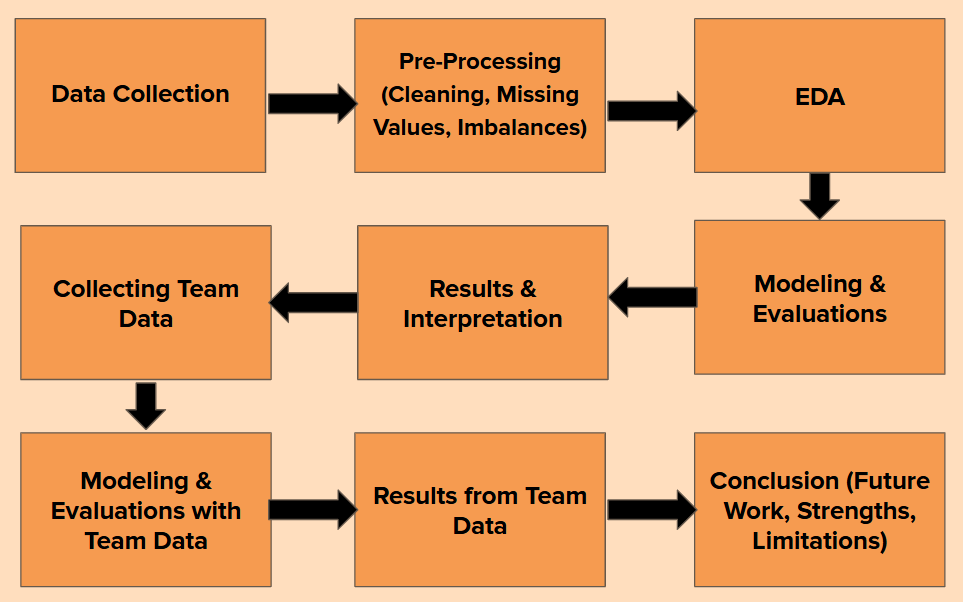

In [1]:
import requests
from bs4 import BeautifulSoup

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import (
    train_test_split,
    cross_validate,
    cross_val_score,
    cross_val_predict,
    GridSearchCV
)
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    confusion_matrix,
    roc_curve,
    auc
)

from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.inspection import permutation_importance

from io import StringIO
import time


 Our code relies on several key libraries for data collection, processing, visualization, and machine learning. For web scraping, requests and BeautifulSoup collect and parse website data. Data manipulation is handled by pandas and numpy, while visualization is done using matplotlib.pyplot and seaborn.

For machine learning, scikit-learn provides models like LogisticRegression and RandomForestClassifier, along with tools for evaluation (cross_validate, classification_report, roc_auc_score), preprocessing (StandardScaler, PolynomialFeatures), and hyperparameter tuning (GridSearchCV). Pipeline and ColumnTransformer streamline workflows, and permutation_importance analyzes feature impacts. To address imbalanced datasets, SMOTE generates synthetic samples. These libraries collectively enable efficient data handling, model training, and result interpretation.

In [2]:
start_time = time.time()

# Question/Problem

Which individual performance metrics most accurately predict the likelihood of an NBA player winning the MVP award in a given season?

The NBA MVP (Most Valuable Player) is an annual award given to the player who is deemed to have had the most outstanding performance and impact during the regular season. Our group would like to explore the relationship between individual performance metrics and the likelihood of an NBA player winning the MVP award in a given season. The problem is based on the difficulty of determining what truly defines an MVP, as the selection process often involves subjective factors and varies based on evolving league priorities and voter preferences. By analyzing features like points per game, assists, rebounds, and field goal percentage, the goal is to identify which metrics are most strongly associated with MVP-caliber performance. This analysis can provide insights into how the league values different aspects of a player's contributions and how these trends have evolved over time. Understanding these predictors can also help in forecasting future MVPs or evaluating the impact of specific performance factors on award selection.

# Collecting Data

## Collecting MVP Data


In [3]:
MVP_url = "https://www.basketball-reference.com/awards/mvp.html"

response = requests.get(MVP_url)
soup = BeautifulSoup(response.content, 'html.parser')

table = soup.find('table', {'id': 'mvp_NBA'})

# Extract headers from the second row of the <thead> only (top row is )
header_row = table.find('thead').find_all('tr')[1]
headers = [th.get_text() for th in header_row.find_all('th')]

# Extract rows
rows = []
for row in table.find('tbody').find_all('tr'):
    cells = row.find_all(['th', 'td'])
    row_data = []

    for i, cell in enumerate(cells):
        row_data.append(cell.get_text())

    # Ensure the row length matches header length
    if len(row_data) < len(headers):
        row_data.extend(['N/A'] * ((len(headers)) - len(row_data)))
    rows.append(row_data)

MVP_df = pd.DataFrame(rows, columns=headers)

# Convert numeric columns to handle missing placeholders
numeric_cols = ["Age", "G", "MP", "PTS", "TRB", "AST", "STL", "BLK", "FG%", "3P%", "FT%", "WS", "WS/48"]
for col in numeric_cols:
    MVP_df[col] = pd.to_numeric(MVP_df[col], errors='coerce')

# Drop the unnecessary columns
MVP_df = MVP_df.drop(columns=['Lg', 'Voting', 'Age'])
# Create the DPC feature as an interaction term (product of steals and blocks)
MVP_df['DPC'] = MVP_df['STL'] * MVP_df['BLK']

MVP_df['MVP'] = 1

def convert_season_to_year(season):
    # Extract the starting year and ending digits
    start_year = int(season.split('-')[0])
    end_digits = season.split('-')[1]

    # Calculate the full end year correctly based on end_digits
    end_year = start_year + 1 if len(end_digits) == 2 and int(end_digits) > int(start_year % 100) else start_year + 100

    return end_year

MVP_df['Season'] = MVP_df['Season'].apply(convert_season_to_year)

MVP_df.to_csv("mvp_data.csv", index=False)

In [4]:
MVP_df.head()

,Season,Player,Tm,G,MP,PTS,TRB,AST,STL,BLK,FG%,3P%,FT%,WS,WS/48,DPC,MVP
0,2024,Nikola Jokić,DEN,79,34.6,26.4,12.4,9.0,1.4,0.9,0.583,0.359,0.817,17.0,0.299,1.26,1
1,2023,Joel Embiid,PHI,66,34.6,33.1,10.2,4.2,1.0,1.7,0.548,0.330,0.857,12.3,0.259,1.70,1
2,2022,Nikola Jokić,DEN,74,33.5,27.1,13.8,7.9,1.5,0.9,0.583,0.337,0.810,15.2,0.296,1.35,1
3,2021,Nikola Jokić,DEN,72,34.6,26.4,10.8,8.3,1.3,0.7,0.566,0.388,0.868,15.6,0.301,0.91,1
4,2020,Giannis Antetokounmpo,MIL,63,30.4,29.5,13.6,5.6,1.0,1.0,0.553,0.304,0.633,11.1,0.279,1.00,1


## Collecting non MVP data

Adding 50 of the top scorers each year from 2023 to 2000... 1200 entries

In [5]:
def get_non_mvp_data(year):
    url = f"https://www.basketball-reference.com/leagues/NBA_{year}_per_game.html"
    response = requests.get(url)
    soup = BeautifulSoup(response.content, "html.parser")

    table = soup.find("table", {"id": "per_game_stats"})
    rows = table.find("tbody").find_all("tr")

    data = []
    for row in rows[:50]:
        player_data = {}
        for cell in row.find_all(["th", "td"]):
            data_stat = cell.get("data-stat")
            text = cell.get_text()

            if data_stat == "name_display":
                player_data["Player"] = text
            elif data_stat == "age":
                player_data["Age"] = text
            elif data_stat == "team_name_abbr":
                player_data["Team"] = text
            elif data_stat == "pos":
                player_data["Pos"] = text
            elif data_stat == "games":
                player_data["G"] = text
            elif data_stat == "games_started":
                player_data["GS"] = text
            elif data_stat == "mp_per_g":
                player_data["MP"] = text
            elif data_stat == "fg_per_g":
                player_data["FG"] = text
            elif data_stat == "fga_per_g":
                player_data["FGA"] = text
            elif data_stat == "fg_pct":
                player_data["FG%"] = text
            elif data_stat == "fg3_per_g":
                player_data["3P"] = text
            elif data_stat == "fg3a_per_g":
                player_data["3PA"] = text
            elif data_stat == "fg3_pct":
                player_data["3P%"] = text
            elif data_stat == "fg2_per_g":
                player_data["2P"] = text
            elif data_stat == "fg2a_per_g":
                player_data["2PA"] = text
            elif data_stat == "fg2_pct":
                player_data["2P%"] = text
            elif data_stat == "efg_pct":
                player_data["eFG%"] = text
            elif data_stat == "ft_per_g":
                player_data["FT"] = text
            elif data_stat == "fta_per_g":
                player_data["FTA"] = text
            elif data_stat == "ft_pct":
                player_data["FT%"] = text
            elif data_stat == "orb_per_g":
                player_data["ORB"] = text
            elif data_stat == "drb_per_g":
                player_data["DRB"] = text
            elif data_stat == "trb_per_g":
                player_data["TRB"] = text
            elif data_stat == "ast_per_g":
                player_data["AST"] = text
            elif data_stat == "stl_per_g":
                player_data["STL"] = text
            elif data_stat == "blk_per_g":
                player_data["BLK"] = text
            elif data_stat == "tov_per_g":
                player_data["TOV"] = text
            elif data_stat == "pf_per_g":
                player_data["PF"] = text
            elif data_stat == "pts_per_g":
                player_data["PTS"] = text
            elif data_stat == "awards":
                player_data["Awards"] = text

        player_data["Season"] = year
        data.append(player_data)

    return pd.DataFrame(data)

# Collect data for a range of seasons
all_non_mvp_data = []
for year in range(2000, 2024):
    season_data = get_non_mvp_data(year)
    all_non_mvp_data.append(season_data)
    print(f"Collected data for season {year}")

# Combine all seasons into a single DataFrame and save as CSV
non_mvp_df = pd.concat(all_non_mvp_data, ignore_index=True)
non_mvp_df.to_csv("non_mvp_data.csv", index=False)
print("Non-MVP data saved to non_mvp_data.csv")

Collected data for season 2000
Collected data for season 2001
Collected data for season 2002
Collected data for season 2003
Collected data for season 2004
Collected data for season 2005
Collected data for season 2006
Collected data for season 2007
Collected data for season 2008
Collected data for season 2009
Collected data for season 2010
Collected data for season 2011
Collected data for season 2012
Collected data for season 2013
Collected data for season 2014
Collected data for season 2015
Collected data for season 2016
Collected data for season 2017
Collected data for season 2018
Collected data for season 2019
Collected data for season 2020
Collected data for season 2021
Collected data for season 2022
Collected data for season 2023
Non-MVP data saved to non_mvp_data.csv


# Preprocessing

**Cleaning data**

1. Keep columns of only individual metrics that are in both tables
2. Remove any MVP rows from the non MVP dataset (as to not double count)
3. Add MVP=0 for all non MVPs
4. Combine tables

In [6]:
mvp_df = pd.read_csv('mvp_data.csv')
non_mvp_df = pd.read_csv('non_mvp_data.csv')

# Rename columns in non_mvp_df to align with mvp_df columns
non_mvp_df = non_mvp_df.rename(columns={
    "Team": "Tm",
    "Player": "Player",
    "PTS": "PTS",
    "TRB": "TRB",
    "AST": "AST",
    "STL": "STL",
    "BLK": "BLK",
    "MP": "MP",
    "G": "G",
    "FG%": "FG%",
    "3P%": "3P%",
    "FT%": "FT%",
})

non_mvp_df['MVP'] = 0

# Identify the columns that overlap between both tables
common_columns = list(set(mvp_df.columns).intersection(set(non_mvp_df.columns)))

# Filter both datasets to keep only the common columns
mvp_df = mvp_df[common_columns]
non_mvp_df = non_mvp_df[common_columns]

# Create a set of MVP player names per season to exclude from non-MVP data
mvp_players = set(zip(mvp_df['Player'], mvp_df['Season']))
non_mvp_df = non_mvp_df[~non_mvp_df.apply(lambda row: (row['Player'], row['Season']) in mvp_players, axis=1)]

combined_df = pd.concat([mvp_df, non_mvp_df], ignore_index=True)

combined_df.to_csv("combined_data.csv", index=False)

In [7]:
non_mvp_df.head()

,G,Player,MVP,Season,FG%,TRB,MP,3P%,AST,FT%,STL,Tm,PTS,BLK
0,79,Shaquille O'Neal,0,2000,0.574,13.6,40.0,0.000,3.8,0.524,0.5,LAL,29.7,3.0
1,70,Allen Iverson,0,2000,0.421,3.8,40.8,0.341,4.7,0.713,2.1,PHI,28.4,0.1
2,74,Grant Hill,0,2000,0.489,6.6,37.5,0.347,5.2,0.795,1.4,DET,25.8,0.6
3,82,Vince Carter,0,2000,0.465,5.8,38.1,0.403,3.9,0.791,1.3,TOR,25.7,1.1
4,82,Karl Malone,0,2000,0.509,9.5,35.9,0.250,3.7,0.797,1.0,UTA,25.5,0.9


In [8]:
combined_df.describe()

,G,MVP,Season,FG%,TRB,MP,3P%,AST,FT%,STL,PTS,BLK
count,1247.000000,1247.000000,1247.000000,1247.000000,1247.000000,1247.000000,1206.000000,1247.000000,1247.000000,1229.000000,1247.000000,1229.000000
mean,66.152366,0.055333,2010.375301,0.466364,6.580353,35.695830,0.326299,4.366640,0.800751,1.182343,21.459583,0.684703
std,17.019323,0.228720,9.884419,0.043197,3.250942,3.126834,0.104493,2.239832,0.079474,0.451965,3.848614,0.615418
min,1.000000,0.000000,1956.000000,0.329000,0.000000,24.200000,0.000000,0.700000,0.355000,0.000000,12.400000,0.000000
25%,59.000000,0.000000,2005.000000,0.437000,4.200000,33.750000,0.304000,2.600000,0.761000,0.900000,18.600000,0.300000
50%,72.000000,0.000000,2011.000000,0.460000,5.800000,35.700000,0.348000,3.900000,0.813000,1.100000,20.600000,0.500000
75%,79.000000,0.000000,2017.000000,0.491000,8.300000,37.800000,0.383000,5.650000,0.855000,1.500000,23.800000,0.900000
max,83.000000,1.000000,2099.000000,0.683000,27.000000,47.300000,1.000000,12.800000,1.000000,3.200000,37.600000,4.100000


**Addressing data imbalance**

Currently, the combined dataset has 1187 non MVP instances, and 70 MVP instances (as there much less MVPs than non MVPs in any given season)

We will run a *SMOTE* model in order to create synthetic MVP instances that will balance our dataset

SMOTE generates synthetic instances of the minority class by interpolating between existing samples, rather than simply duplicating them. This approach helps to:

1. Balance the dataset, ensuring the model is trained on an equal representation of MVP and non-MVP cases.

2. Prevent overfitting to the minority class by avoiding repeated duplication of rare instances.

3. Improve the model's ability to generalize and accurately predict MVP instances.

Before applying SMOTE, we remove identifying variables such as name, team, and season to prevent the model from learning spurious correlations. This ensures the synthetic instances are generated based solely on the relevant features of interest.

Additionally, we handle missing data through appropriate imputation methods to maintain data integrity. By addressing missing values before applying SMOTE, we ensure the synthetic data accurately reflects the underlying patterns in the original dataset, reducing the risk of introducing noise.

More data cleaning (dealing with missing values)

In [9]:
data = pd.read_csv('combined_data.csv')

# MVPs before 1974 didn't have blocks and steals measured, so populating with the averages across all MVPS

stl_mvp_mean = data[data['MVP'] == 1]['STL'].mean()
blk_mvp_mean = data[data['MVP'] == 1]['BLK'].mean()

data['STL'] = data['STL'].fillna(stl_mvp_mean)
data['BLK'] = data['BLK'].fillna(blk_mvp_mean)

# 3 point percentage wasn't measured until 1979, so populating as a 40% offset from the field goal percentage (people shot worse from 3 at this time)
data['3P%'] = data.apply(lambda row: max(row['FG%'] - 0.4, 0) if pd.isna(row['3P%']) else row['3P%'], axis=1)

**Running SMOTE**

In [10]:
# Define features by removing identifiers and target variable
X = data.drop(columns=['MVP', 'Player', 'Season', 'Tm'])
y = data['MVP']

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)

balanced_data = pd.DataFrame(X_smote, columns=X.columns)
balanced_data['MVP'] = y_smote

balanced_data = balanced_data.round(1)

balanced_data.to_csv('full_dataset.csv', index=False)

At last, we have 'full_dataset.csv', which has over 2000 rows of MVP and non MVP data

------------------------------------------------------------

# **Exploratory Data Analysis (EDA)**

In [11]:
# Add full_dataset.csv to folders section
main_df = pd.read_csv('full_dataset.csv')
y_train = main_df["MVP"]

In [12]:
print(f"Class Distribution:\n{pd.Series(y_train).value_counts()}")

Class Distribution:
MVP
1    1178
0    1178
Name: count, dtype: int64


## General Description of the Data: Data, Data types, and Descriptive Statistics

In [13]:
print(main_df[main_df["MVP"] == 1].shape)
main_df.describe().round(2)

(1178, 11)


,G,FG%,TRB,MP,3P%,AST,FT%,STL,PTS,BLK,MVP
count,2356.00,2356.00,2356.00,2356.00,2356.00,2356.00,2356.00,2356.00,2356.00,2356.00,2356.0
mean,71.47,0.49,9.09,37.16,0.28,5.00,0.78,1.34,23.64,1.02,0.5
std,14.19,0.06,5.28,3.62,0.13,2.45,0.10,0.45,4.76,0.83,0.5
min,1.00,0.30,0.00,24.20,0.00,0.70,0.40,0.00,12.40,0.00,0.0
25%,67.00,0.40,5.18,34.70,0.20,3.20,0.70,1.00,19.60,0.40,0.0
50%,78.00,0.50,7.60,37.00,0.30,4.60,0.80,1.40,23.50,0.80,0.5
75%,81.00,0.50,11.80,39.00,0.40,6.20,0.90,1.60,27.10,1.40,1.0
max,83.00,0.70,27.00,47.30,1.00,12.80,1.00,3.20,37.60,4.10,1.0


In [14]:
main_df.head()

,G,FG%,TRB,MP,3P%,AST,FT%,STL,PTS,BLK,MVP
0,79,0.6,12.4,34.6,0.4,9.0,0.8,1.4,26.4,0.9,1
1,66,0.5,10.2,34.6,0.3,4.2,0.9,1.0,33.1,1.7,1
2,74,0.6,13.8,33.5,0.3,7.9,0.8,1.5,27.1,0.9,1
3,72,0.6,10.8,34.6,0.4,8.3,0.9,1.3,26.4,0.7,1
4,63,0.6,13.6,30.4,0.3,5.6,0.6,1.0,29.5,1.0,1


## Summary of the Features: Violin plots for Each attribute

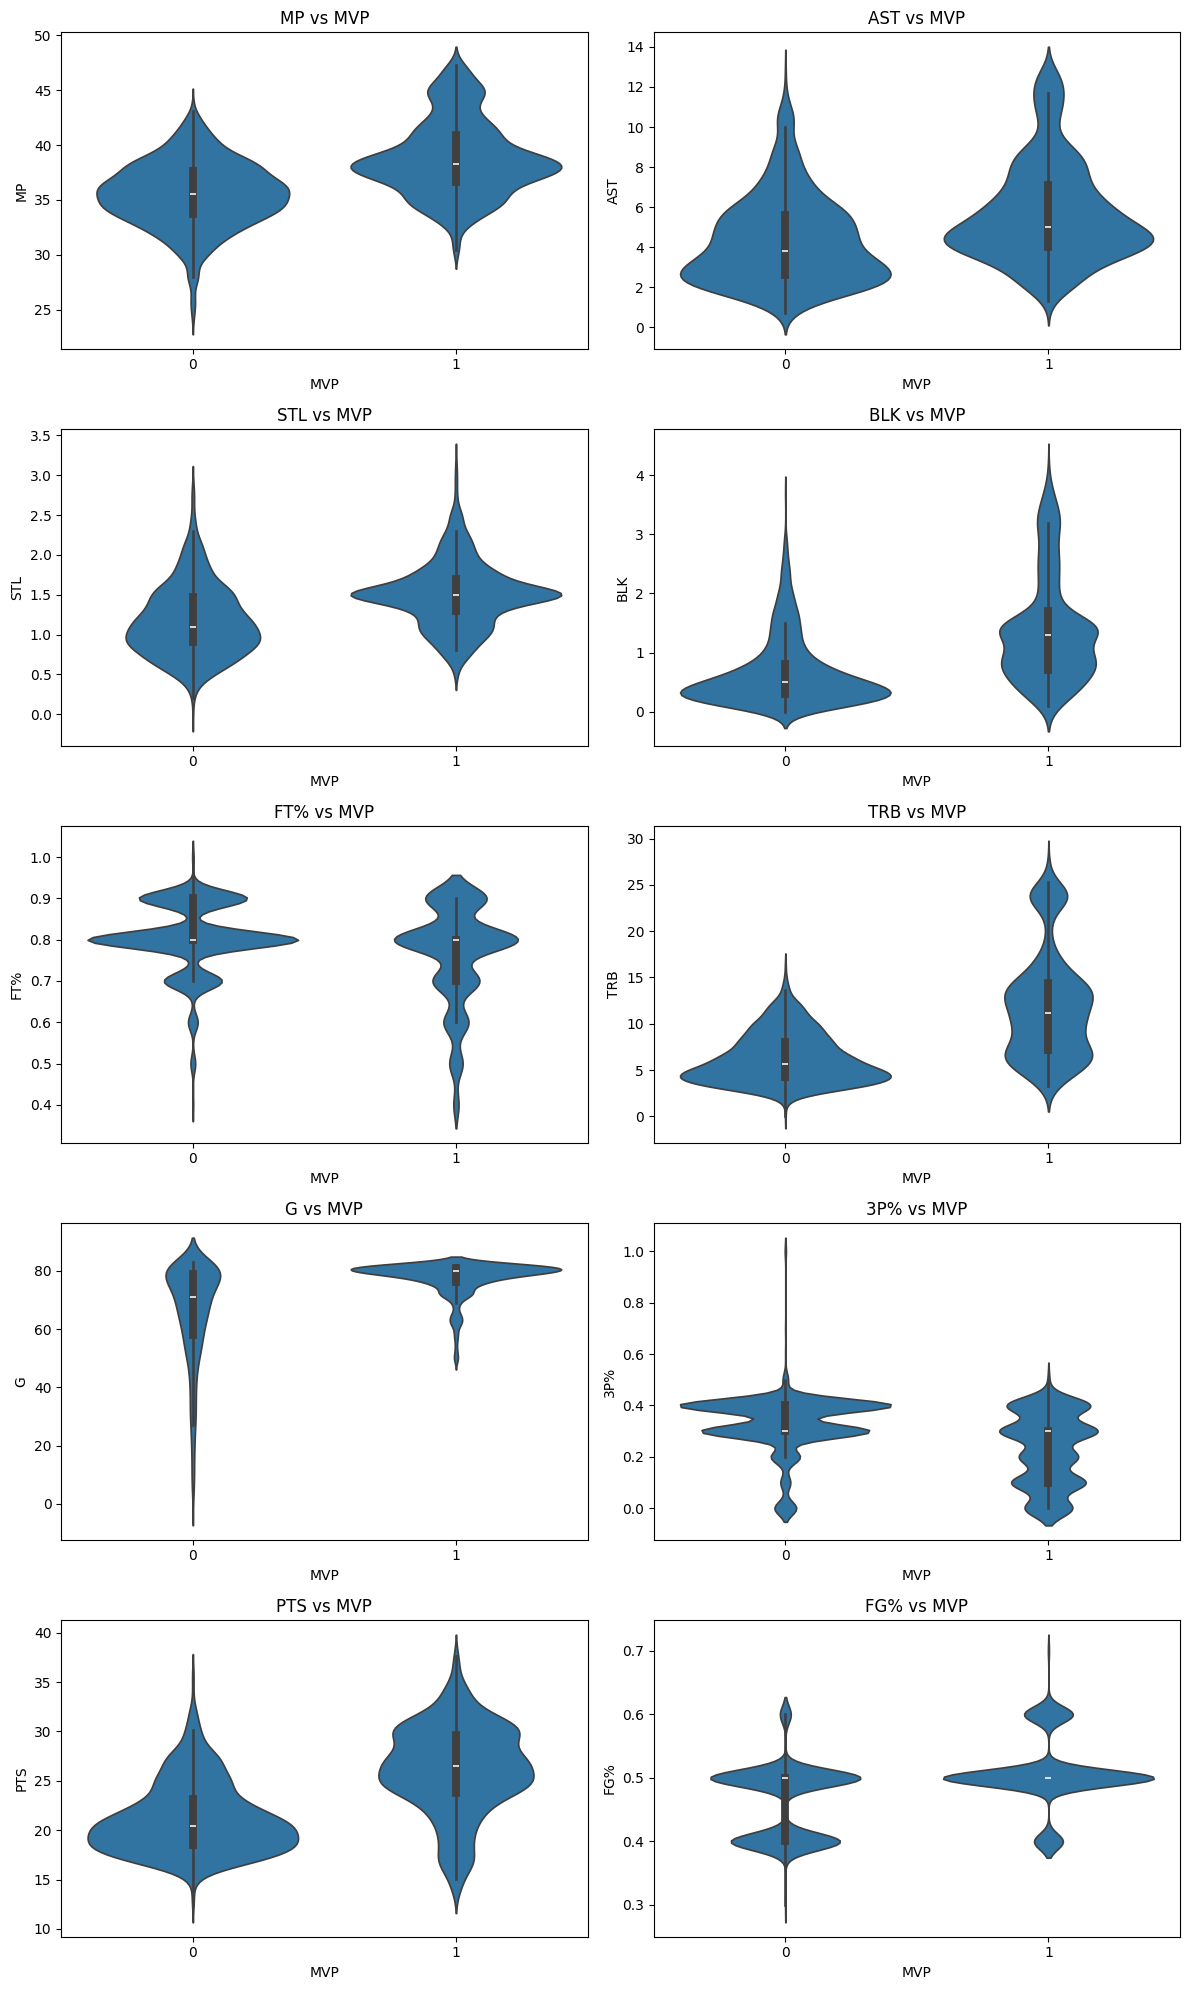

In [15]:
preds = ["MP", "AST", "STL", "BLK", "FT%", "TRB", "G", "3P%", "PTS", "FG%"]

fig, axs = plt.subplots(5, 2, figsize=(12, 20))

for i, pred in enumerate(preds):
    row, col = i // 2, i % 2
    sns.violinplot(x=main_df['MVP'], y=main_df[pred], ax=axs[row, col])
    axs[row, col].set_title(f"{pred} vs MVP")
    axs[row, col].set_xlabel('MVP')
    axs[row, col].set_ylabel(pred)

plt.tight_layout()
plt.show()

A feature is likely a strong predictor of MVP status if the left and right violins differ significantly with minimal overlap. Features like PTS, FG%, G, and TRB appear to be strong predictors, while FT% looks like a poor predictor. Interestingly, 3P% and FT% show an inverse correlation with MVP status, which might indicate shared weaknesses among MVPs. This could also be because SMOTE may have amplified outliers in our limited set of MVPs, a factor we can monitor by comparing results with and without SMOTE.


## Summary of the Features: Correlation Matrix

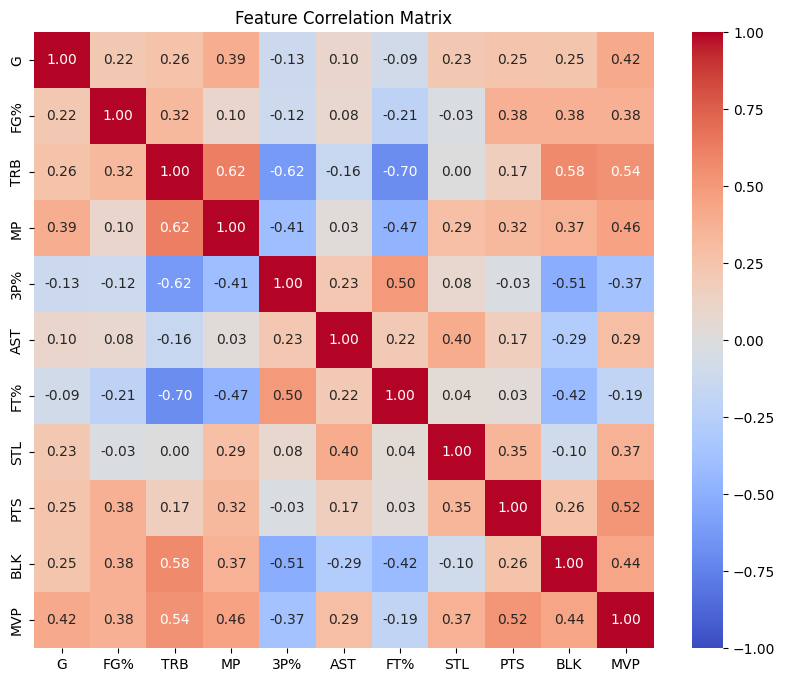

In [16]:
correlation_matrix = main_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", vmin=-1, vmax=1)
plt.title("Feature Correlation Matrix")
plt.show()

The correlation matrix reveals that PTS, TRB, MP, FG% have moderate positive correlations with MVP status, agreeing with the previous analysis and suggesting these metrics are likely key predictors of MVP selection. No features show high correlations with each other, indicating that multicollinearity is minimal, so these features can be included without redundancy.


## Deeper Understanding: Identifying Patterns

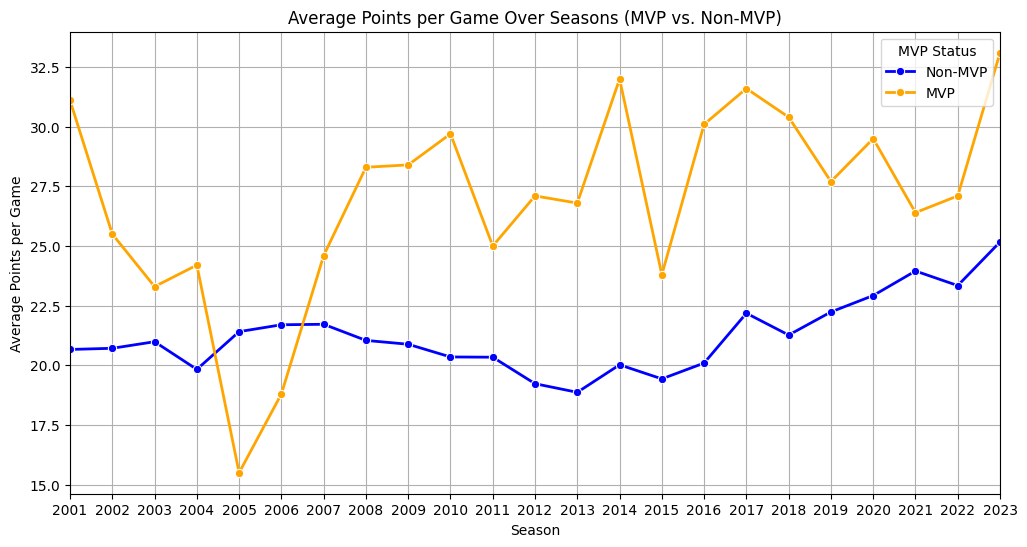

In [17]:
avg_points_per_season = combined_df.groupby(['Season', 'MVP'])['PTS'].mean().reset_index()
overlap_seasons = avg_points_per_season.groupby('Season').filter(lambda x: len(x) == 2)
plt.figure(figsize=(12, 6))
plot = sns.lineplot(data=overlap_seasons, x='Season', y='PTS', hue='MVP', marker='o', linewidth=2, markersize=6, palette=['blue', 'orange'])
plt.xlim(overlap_seasons['Season'].min(), overlap_seasons['Season'].max())
plot.set_xticks(overlap_seasons['Season'].unique())
plot.set_xticklabels(overlap_seasons['Season'].unique().astype(int))
plt.title('Average Points per Game Over Seasons (MVP vs. Non-MVP)')
plt.xlabel('Season')
plt.ylabel('Average Points per Game')
handles, labels = plot.get_legend_handles_labels()
plt.legend(handles=handles, labels=['Non-MVP', 'MVP'], title='MVP Status', loc='upper right')
plt.grid(True)
plt.show()

MVPs consistently score higher on average than non-MVPs, with a recent upward trend in points per game for both groups, suggesting a shift toward higher scoring in the NBA. The stable scoring gap between MVPs and non-MVPs indicates that scoring ability remains a key factor in MVP selection, which implies that scoring prowess has consistently influenced MVP criteria over time. Analyzing this trend helps us understand whether the NBA's standards for MVP selection have shifted or remained stable in prioritizing high-scoring players. We may have to incorporate year data (which has been scraped but so far not included in the main features) to account for trends over time in the model.


## Deeper Understanding: Outliers and Confounders

<ipython-input-18-bc9f1b5c26d2>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mvp_players['Era'] = mvp_players['Season'].apply(get_era)


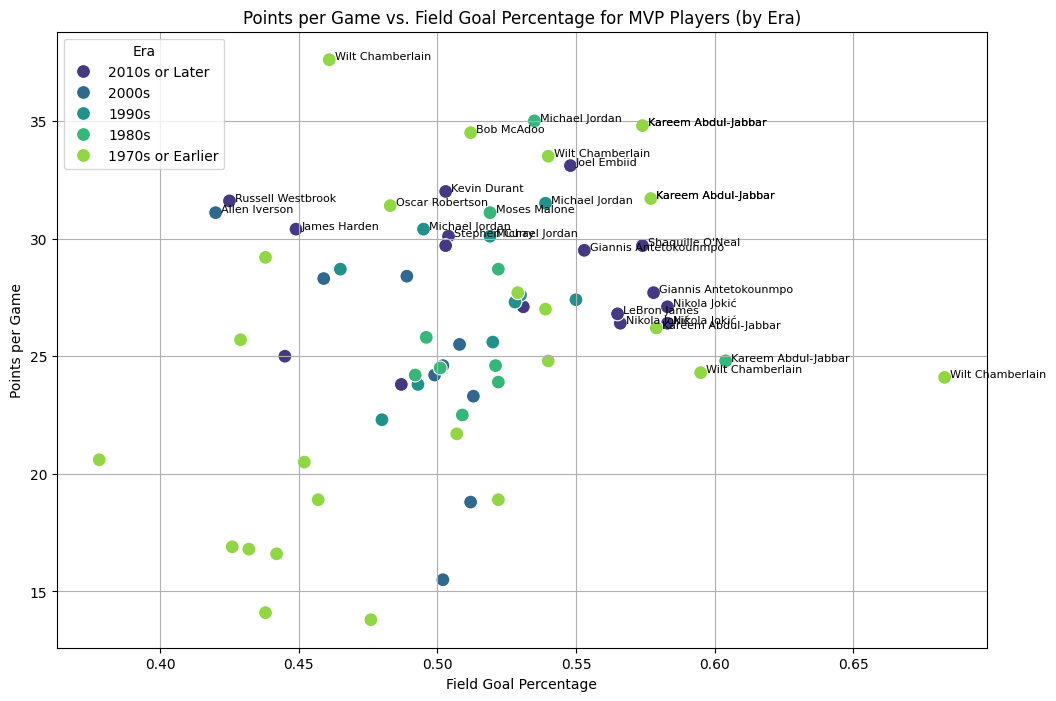

In [18]:
mvp_players = combined_df[combined_df['MVP'] == 1]
def get_era(season):
    if season < 1980:
        return '1970s or Earlier'
    elif season < 1990:
        return '1980s'
    elif season < 2000:
        return '1990s'
    elif season < 2010:
        return '2000s'
    else:
        return '2010s or Later'

mvp_players['Era'] = mvp_players['Season'].apply(get_era)
top_scorers = mvp_players[mvp_players['PTS'] > 30]
high_efficiency = mvp_players[mvp_players['FG%'] > 0.55]

plt.figure(figsize=(12, 8))
sns.scatterplot(x='FG%', y='PTS', hue='Era', data=mvp_players, palette='viridis', s=100)
plt.title('Points per Game vs. Field Goal Percentage for MVP Players (by Era)')
plt.xlabel('Field Goal Percentage')
plt.ylabel('Points per Game')
plt.grid(True)

for i, row in top_scorers.iterrows():
    plt.text(row['FG%'] + 0.002, row['PTS'], row['Player'], color='black', fontsize=8, weight='normal')

for i, row in high_efficiency.iterrows():
    plt.text(row['FG%'] + 0.002, row['PTS'], row['Player'], color='black', fontsize=8, weight='normal')

plt.legend(title='Era', loc='upper left')
plt.show()

This scatter plot of points per game versus field goal percentage for MVPs, colored by era, highlights scoring volume and efficiency trends among MVP players. Outliers like Wilt Chamberlain and Michael Jordan demonstrate exceptional performances in scoring or efficiency. Recent MVPs achieve similar scoring with higher efficiency, suggesting a shift in MVP standards toward valuing efficiency. The positive relationship between points per game and field goal percentage indicates that scoring efficiency may influence MVP selection, providing insights into the evolving qualities that define MVP-caliber players


# Baseline model
This baseline model is a simple logistic regression, trained on the entire dataset and feature set, evaluated on accuracy with 10-fold CV. We will be comparing the performance of this model to various other models, including LASSO-based log-reg models with different values of lambda (i.e. to reduce collinearity).


## Train/Validation/Test

In [21]:
X = main_df[preds]
y = main_df["MVP"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Model Training

In [22]:
baseline_model = LogisticRegression(max_iter=1000, random_state=42)
baseline_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

## Evaluation of Model Performance on Unseen Data

In [23]:
cv_results = cross_validate(baseline_model, X, y, cv=10, scoring='accuracy', return_train_score=True)
print(f"Mean CV Train Accuracy: {cv_results['train_score'].mean():.4f}")
print(f"Mean CV Test Accuracy: {cv_results['test_score'].mean():.4f}")

y_pred = baseline_model.predict(X_test)
y_pred_proba = baseline_model.predict_proba(X_test)[:, 1]

# Classification report
report = classification_report(y_test, y_pred, target_names=["Non-MVP", "MVP"])
print("Classification Report:\n", report)

# ROC-AUC Score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC-AUC Score: {roc_auc:.4f}")

Mean CV Train Accuracy: 0.9176
Mean CV Test Accuracy: 0.9113
Classification Report:
               precision    recall  f1-score   support

     Non-MVP       0.94      0.91      0.92       236
         MVP       0.91      0.94      0.93       236

    accuracy                           0.92       472
   macro avg       0.92      0.92      0.92       472
weighted avg       0.92      0.92      0.92       472

ROC-AUC Score: 0.9759


Our baseline model has train and test scores both around 0.91; since they are similar, it's likely that our model has not overfit to the training data. Our model has higher recall than precision for MVP predictions, indicating that our model prioritizes capturing most positive instances, although some of its positive predictions will be false positives. This is likely a consequence of using SMOTE -- since we artificially generated a bunch of MVP candidates in a concentrated region in the feature space, our model might be a bit too trigger-happy to predict that anyone in that region will be an MVP.

MP -0.022451491970946893
AST 1.9657575793511703
STL 0.792042245074139
BLK 0.7372216312258463
FT% 1.4083173383612109
TRB 2.546999767061352
G 1.3172891399148985
3P% -1.4143854466800145
PTS 1.3892178811870493
FG% 0.5435297034869904


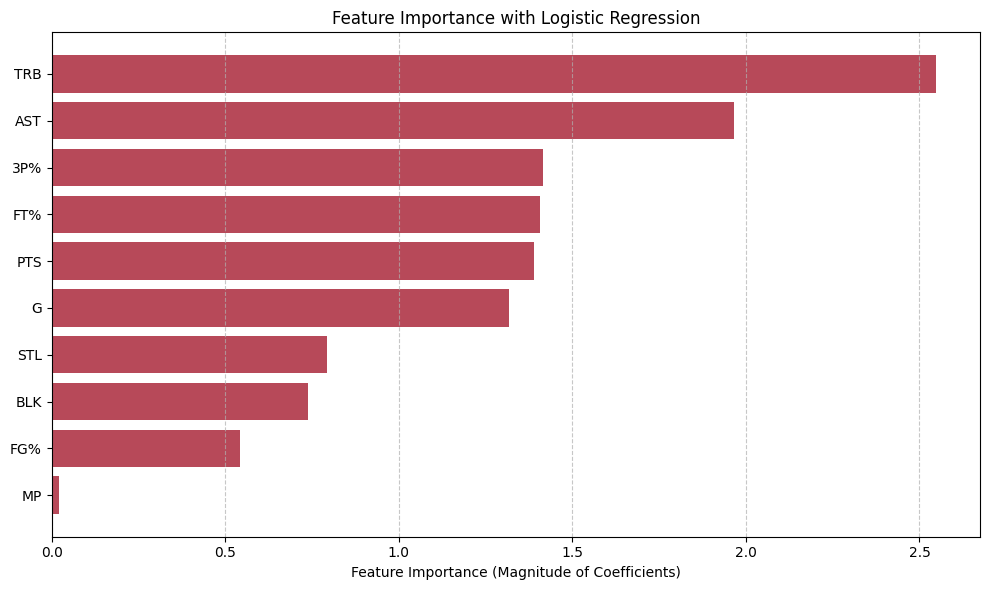

In [24]:
# Feature Importance
coefficients = baseline_model.coef_[0]
importance_mean = np.abs(coefficients)
for i in range(len(X.columns)):
  print(X.columns[i], coefficients[i])

feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importance_mean
}).sort_values(by='Importance', ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_importance)), feature_importance['Importance'], color='#A51C30', alpha=0.8)
plt.yticks(range(len(feature_importance)), feature_importance['Feature'])
plt.xlabel('Feature Importance (Magnitude of Coefficients)')
plt.title('Feature Importance with Logistic Regression')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

LASSO coefficients give us a preliminary answer for our original research question: it looks like total rebounds is the most important predictor for MVP status, with the highest magnitude coefficient.

As we predicted with the violin plots in the EDA stage, most predictors are positively associated with MVP status, indicated by a positive coefficient, with 3 point percentage being inversely associated and having a negative coefficient. However, we predicted that FT% would not be relevant, but it turned out to have one of the highest coefficients -- the regression may have detected relationships that the violin plot did not pick up on.

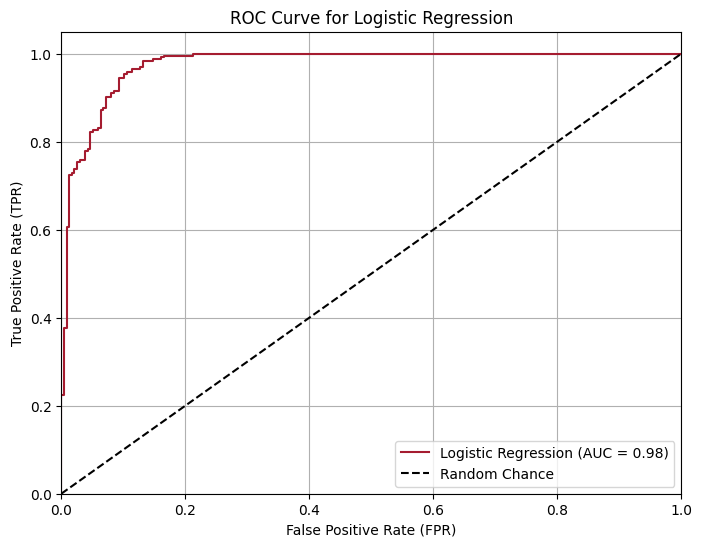

In [25]:
# ROC Curve
y_proba = baseline_model.predict_proba(X_test)

fpr, tpr, _ = roc_curve(y_test, y_proba[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {roc_auc:.2f})', color='#A51C30')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for Logistic Regression')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [26]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:\n", cm)


Confusion Matrix:
 [[214  22]
 [ 14 222]]


The AUC score (shown in the Classification Report) is 0.96, indicating that the model is excellent at discriminating between classes. The curve has a steep slope as TPR is increased beyond 0.7; the curve achieves a TRP of ~1.0 with an FPR of only ~0.15, indicating that the model can pick out virtually all the MVPs if we allow it to wrongly include ~15% of non-MVPs in that class as well. The model's especially good TPR with the default probability threshold of 0.5 is showcased in the confusion matrix as well. This might not be useful for, say, a medical diagnosis scenario, but this could be excellent for a betting scenario, where we could hypothetically make multiple bets on who will be MVP to "cover all our bases" and have a very high probability of one bet paying off.

**Model Weaknesses**

Surprisingly, our baseline logistic regression model had strong overall performance, with a cross-validated test accuracy of 90.92% and an excellent ROC-AUC of 0.9772. This means that the model effectively was able to separate between MVPs and Non-MVPs. However, there is a slight concern on how the model's reliance on linear relationships limits its ability to capture more complex interactions between features, such as the combined impact of scoring (PTS) and assists (AST). When we did feature importance analysis, we found  that TRB (total rebounds) has the strongest coefficient, which may not align with real-world MVP selection criteria, where scoring is often more valued. Additionally, the negative coefficient for 3P% suggests potential issues in how certain features are weighted or interact since we would expect in the real world to have a great 3P% to mean higher likelihood of winning MVP. While the balanced dataset using SMOTE mitigated our issue with sampling bias, the model may still struggle with borderline MVP candidates, especially those with mixed performance metrics. Another thing is that the model does not account for intangible factors like team success, leadership, or media narrative, which are crucial for MVP selection but beyond the scope of the dataset. Finally, one notable weakness of the model is that it doesn't fully account for the evolving nature of the MVP selection criteria. Historically, rebounding (TRB) has been a strong predictor because MVPs were often dominated by big men, such as centers and power forwards. However, the league is shifting toward valuing versatility and shooting efficiency, with an increasing emphasis on three-point shooting (3P%). This trend suggests that in the near future, metrics like 3P% may become much more critical for predicting MVPs, which the current model might fail to capture effectively.

**Next** **Steps**

For the next steps, we can attempt to improve performance by incorporating interaction terms in order to allow the model to capture non-linear relationships between metrics like scoring, rebounding, and shooting percentages. This improvement along with regularization can help refine feature selection and boost the model's ability to predict MVP likelihood more effectively. Furthermore, only if enough time is available, we could potenitally explore other machine learning techniques like Random Forests or Gradient Boosting to handle complex feature interactions and non-linear patterns.

# Final Model Pipeline

For the final model pipeline, we integrate our preprocessing steps and our modelling into one pipeline. Also, we add interaction terms as an extra preprocessing step in our pipeline

In [27]:
X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

numeric_features = X.columns.tolist()

numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2, include_bias=False))
])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)
    ],
    remainder='passthrough'
)


final_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(penalty='l1', solver='saga', max_iter=5000, random_state=42, C=1.0))
])

cv_scores = cross_val_score(final_pipeline, X, y, cv=10, scoring='accuracy')
print(f"Mean CV Accuracy: {cv_scores.mean():.4f}")

final_pipeline.fit(X_train, y_train)

y_pred = final_pipeline.predict(X_test)
y_pred_proba = final_pipeline.predict_proba(X_test)[:, 1]

print("Classification Report:\n", classification_report(y_test, y_pred, target_names=["Non-MVP", "MVP"]))
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_pred_proba):.4f}")

Mean CV Accuracy: 0.9597
Classification Report:
               precision    recall  f1-score   support

     Non-MVP       0.98      0.94      0.96       236
         MVP       0.95      0.98      0.96       236

    accuracy                           0.96       472
   macro avg       0.96      0.96      0.96       472
weighted avg       0.96      0.96      0.96       472

ROC-AUC Score: 0.9912


The final model pipeline significantly improved predictive performance as we see that it achieved a mean cross-validation accuracy of 95.97% and a very high ROC-AUC score of 0.9912. This shows that using interaction terms and L1-penalty logistic regression definitely enhanced the model's ability to capture complex relationships and distinguish between MVPs and non-MVPs.


In [28]:
# Feature importance
coefficients = final_pipeline.named_steps['classifier'].coef_[0]
feature_names = final_pipeline.named_steps['preprocessor'].get_feature_names_out()
lasso_features = {feature: coef for feature, coef in zip(feature_names, coefficients) if abs(coef) > 0.01}

print("\nSelected Features and Coefficients:")
for feature, coef in lasso_features.items():
    feature = feature.replace("num__", "")
    print(f"{feature}: {coef:.4f}")


Selected Features and Coefficients:
MP: -0.8520
AST: 2.4220
STL: 1.0662
BLK: 0.9111
FT%: 1.3268
TRB: 4.1608
G: 1.6530
3P%: -1.8299
PTS: 2.7114
FG%: 0.4997
MP^2: -1.4315
MP AST: -0.6835
MP STL: -0.2125
MP PTS: 0.0152
MP FG%: -0.3996
AST^2: -0.0255
AST STL: -0.5920
AST BLK: 2.1056
AST FT%: 1.3267
AST TRB: -0.2005
AST 3P%: -0.2752
AST PTS: -0.5782
AST FG%: -0.1898
STL^2: -0.1203
STL BLK: -0.7738
STL FT%: -0.8797
STL TRB: -0.5479
STL G: -0.1418
STL PTS: 1.0391
STL FG%: -0.0251
BLK^2: 0.3673
BLK G: 0.5232
BLK 3P%: -0.0637
BLK PTS: -0.1017
FT% TRB: -1.2696
FT% G: 1.1236
FT% 3P%: -0.3208
FT% PTS: -0.3146
FT% FG%: 0.5308
TRB^2: 0.5099
TRB G: 0.2029
TRB 3P%: -0.8647
TRB PTS: 0.2710
TRB FG%: 1.1355
G 3P%: 0.8710
G FG%: 0.1620
3P% PTS: -0.1808
3P% FG%: 1.0018
PTS^2: -0.2756
PTS FG%: 0.7380
FG%^2: -0.6603


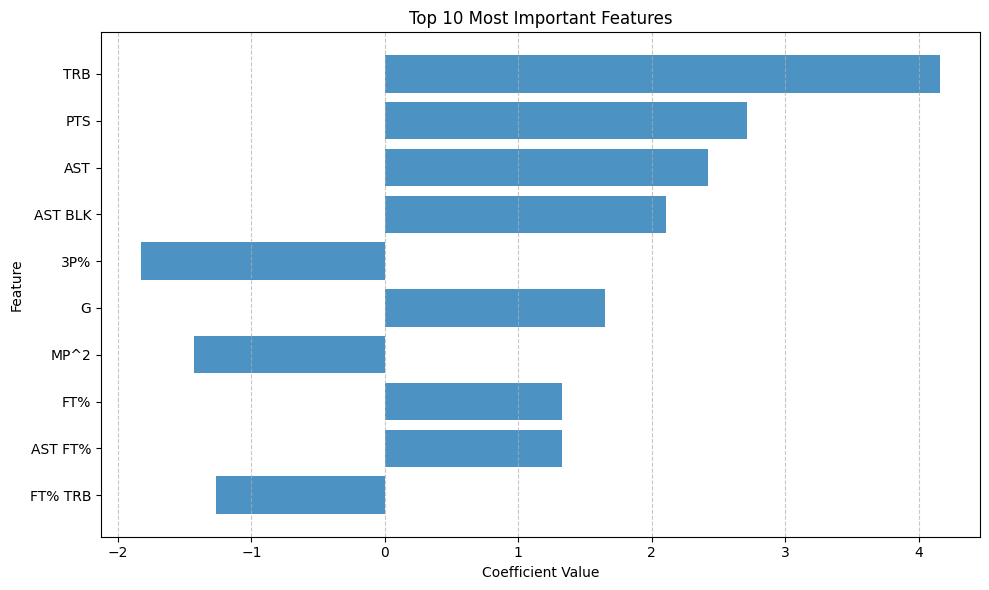

In [29]:
# Visualizing important features
preprocessor_features = final_pipeline.named_steps['preprocessor'].get_feature_names_out()
classifier_coefficients = final_pipeline.named_steps['classifier'].coef_[0]
cleaned_features = [feature.replace("num__", "") for feature in preprocessor_features]

feature_importance = pd.DataFrame({
    'Feature': cleaned_features,
    'Coefficient': classifier_coefficients
}).sort_values(by='Coefficient', key=abs, ascending=False)

# Plotting the top 10 most important features
top_features = feature_importance.head(10)
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Coefficient'], alpha=0.8)
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Top 10 Most Important Features')
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

When we did feature importance analysis, we found that total rebounds (TRB) remained one of the strongest predictors of MVP likelihood, which is consistent with historical trends where big men dominated MVP selections. However, an interesting finding is the strong impact of combining assists (AST) with blocks (BLK), suggesting that players excelling in both playmaking and defense are more likely to be MVPs than those excelling in assists alone. Similarly, features like PTS (points per game) and FT% (free throw percentage) also emerged as significant indicators, which aligns with the league’s emphasis on scoring efficiency. Also, three-point percentage (3P%) still has a negative coefficient, which further suggests that high three-point shooting alone might not significantly contribute to MVP likelihood in the current dataset. However, interaction terms involving 3P%, such as 3P% FG%, did show a positive effect. This implies that three-point efficiency combined with overall field goal success could become increasingly important as the league evolves.

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


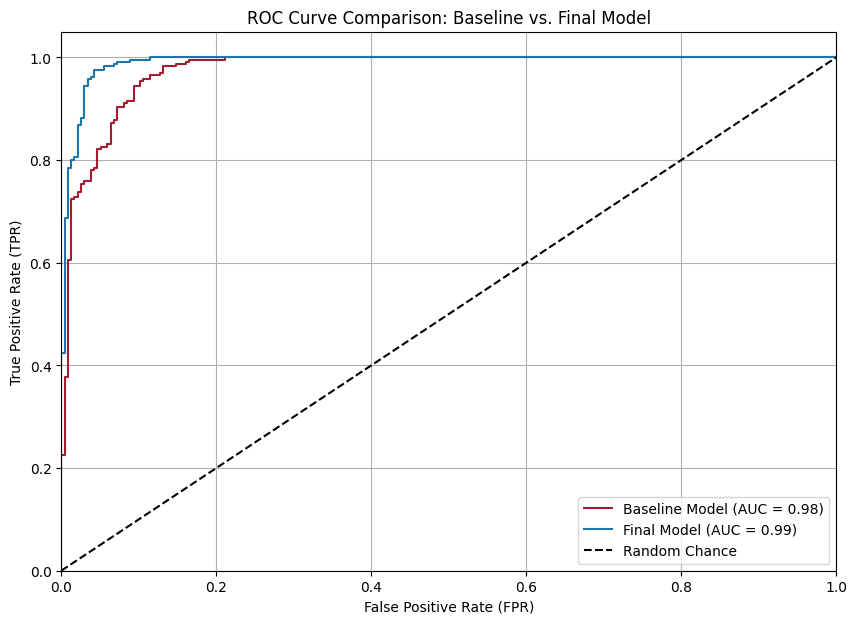

In [30]:
y_proba_baseline = baseline_model.predict_proba(X_test)
fpr_baseline, tpr_baseline, _ = roc_curve(y_test, y_proba_baseline[:, 1])
roc_auc_baseline = auc(fpr_baseline, tpr_baseline)

# Final Model Predictions
y_proba_final = final_pipeline.predict_proba(X_test)
fpr_final, tpr_final, _ = roc_curve(y_test, y_proba_final[:, 1])
roc_auc_final = auc(fpr_final, tpr_final)

plt.figure(figsize=(10, 7))
plt.plot(fpr_baseline, tpr_baseline, label=f'Baseline Model (AUC = {roc_auc_baseline:.2f})', color='#A51C30')
plt.plot(fpr_final, tpr_final, label=f'Final Model (AUC = {roc_auc_final:.2f})', color='#1C77A5')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve Comparison: Baseline vs. Final Model')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Random Forest

In [31]:
baseline_rf = RandomForestClassifier(n_estimators=100, random_state=42)

cv_results = cross_validate(baseline_rf, X_train, y_train, cv=5, scoring='accuracy', return_train_score=True)

print(f"Mean CV Train Accuracy: {cv_results['train_score'].mean():.4f}")
print(f"Mean CV Test Accuracy: {cv_results['test_score'].mean():.4f}")

baseline_rf.fit(X_train, y_train)

y_pred = baseline_rf.predict(X_test)
y_pred_proba = baseline_rf.predict_proba(X_test)[:, 1]

print("Classification Report:\n", classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC-AUC Score: {roc_auc:.4f}")


Mean CV Train Accuracy: 1.0000
Mean CV Test Accuracy: 0.9756
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98       236
           1       0.97      0.99      0.98       236

    accuracy                           0.98       472
   macro avg       0.98      0.98      0.98       472
weighted avg       0.98      0.98      0.98       472

ROC-AUC Score: 0.9986


## Optimized Random Forest
We use cross-validation to tune hyperparameters for # of trees, max depth, minimum # samples at each split, and minimum # of samples in each leaf.

In [32]:
rf = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print(f"Best Cross-Validation Accuracy: {grid_search.best_score_:.4f}")

best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)
y_pred_proba = best_rf.predict_proba(X_test)[:, 1]

print("Classification Report:\n", classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC-AUC Score: {roc_auc:.4f}")


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best Cross-Validation Accuracy: 0.9788
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.98       236
           1       0.97      1.00      0.98       236

    accuracy                           0.98       472
   macro avg       0.98      0.98      0.98       472
weighted avg       0.98      0.98      0.98       472

ROC-AUC Score: 0.9985


The accuracy has significantly improved from the logistic regression, at a nearly perfect 98%. It's unlikely that we overfitted to the hyperparameters through CV since the baseline model has a roughly equal accuracy of 98%. This suggests that our model is truly an excellent predictor on new data.

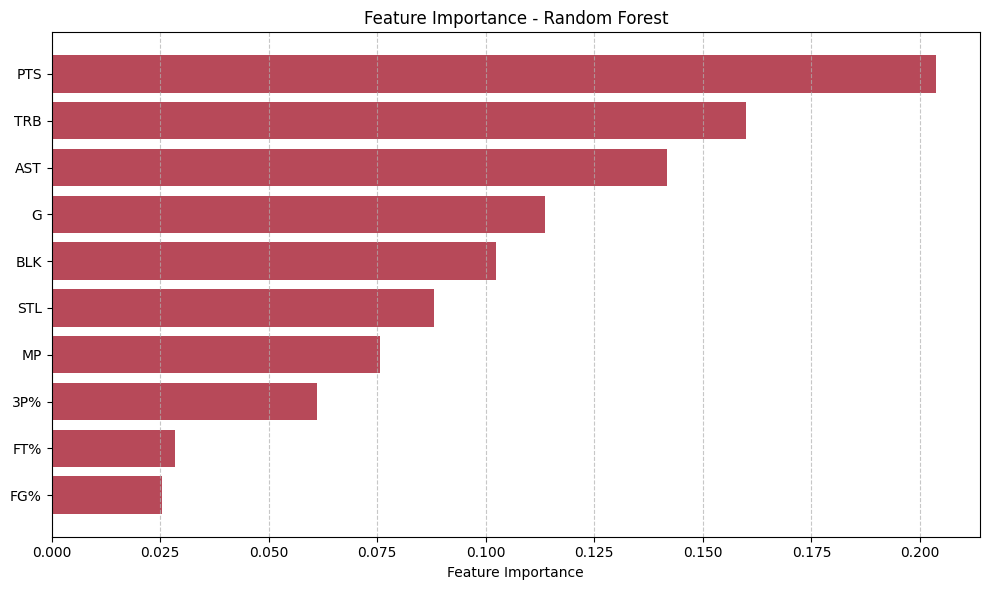

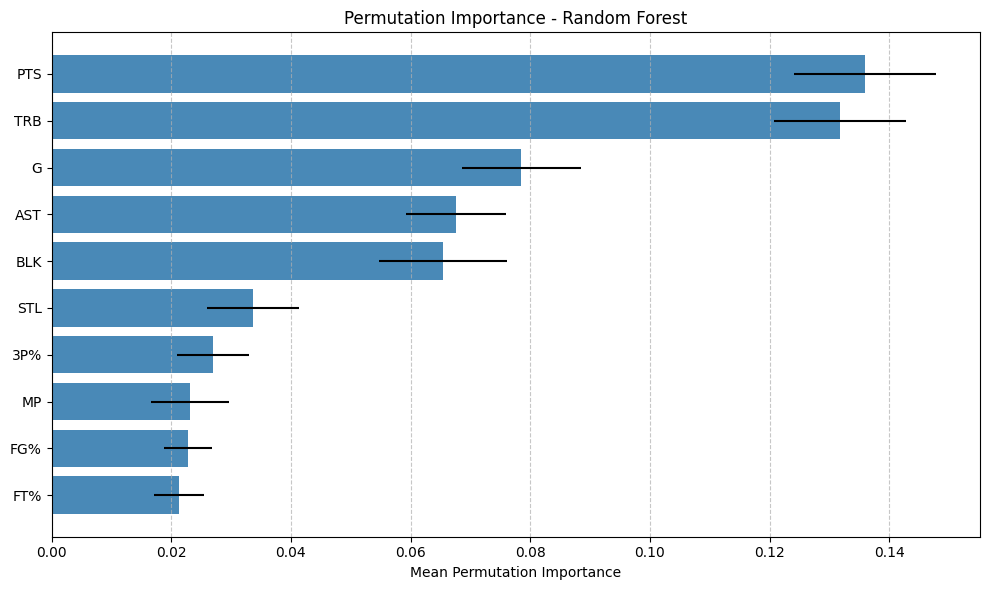

Top 10 Features by Permutation Importance:
  Feature  Importance       Std
8     PTS    0.135946  0.011848
5     TRB    0.131780  0.011028
6       G    0.078531  0.010011
1     AST    0.067655  0.008349
3     BLK    0.065395  0.010688
2     STL    0.033686  0.007704
7     3P%    0.026907  0.006021
0      MP    0.023164  0.006517
9     FG%    0.022811  0.004082
4     FT%    0.021257  0.004219


In [33]:
# Feature Importance
best_rf = grid_search.best_estimator_

feature_importances = best_rf.feature_importances_
features = X_train.columns

feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='#A51C30', alpha=0.8)
plt.xlabel('Feature Importance')
plt.title('Feature Importance - Random Forest')
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Permuation Importance
perm_importance = permutation_importance(best_rf, X_test, y_test, n_repeats=30, random_state=42, n_jobs=-1)

perm_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': perm_importance.importances_mean,
    'Std': perm_importance.importances_std
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(perm_importance_df['Feature'], perm_importance_df['Importance'], xerr=perm_importance_df['Std'], color='#1C6CA5', alpha=0.8)
plt.xlabel('Mean Permutation Importance')
plt.title('Permutation Importance - Random Forest')
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("Top 10 Features by Permutation Importance:")
print(perm_importance_df.head(10))

These results are somewhat different from the results attained by the coefficients in the logistic regression -- PTS and  G are much more important, whereas 3P% and FT% are much less important. We can probably trust these importance values more than the logistic regression ones since the random forest is specifically designed to reduce collinearity and give each variable a chance to be the top split in a decision tree, whereas LASSO tends to pick one variable arbitrarily where there are two collinear features competing for predictive power.

# **What is more important: Individual or Team Statistics?**

We are collecting team data because MVPs are often selected from successful teams, making it essential to consider team performance alongside individual player statistics. Metrics like team wins, defensive rating, and pace help contextualize a player's contribution to their team's success. By incorporating team data, we can better understand how much a player’s MVP candidacy is influenced by their team's overall performance, addressing the debate over whether the MVP award reflects individual excellence, team achievement, or a combination of both.

# Collecting Team Data
Team data is also scraped from Basketball Reference and is included as features in the df alongside individual data.

In [34]:
def scrape_per_100_poss_data(year):
    url = f"https://www.basketball-reference.com/leagues/NBA_{year}.html#per_poss-team"
    response = requests.get(url)
    response.raise_for_status()

    soup = BeautifulSoup(response.content, "lxml")

    # Find the table for per 100 possessions data
    table = soup.find("table", id="per_poss-team")
    if table:
        df = pd.read_html(StringIO(str(table)))[0]

        df.columns = df.columns.droplevel() if isinstance(df.columns, pd.MultiIndex) else df.columns
        df["Year"] = year

        df = df.sort_values(by="Team").reset_index(drop=True)


        return df
    else:
        print(f"Table not found for year {year}")
        return None

# Loop over years and scrape per 100 possessions stats
years = list(range(1956, 2025))
all_data = []

for year in years:
    print(f"Scraping per 100 possessions data for year {year}...")
    df = scrape_per_100_poss_data(year)
    if df is not None:
        all_data.append(df)
    time.sleep(2)

per_100_poss_stats_df = pd.concat(all_data, ignore_index=True)

per_100_poss_stats_df.to_csv("per_100_possession_stats_2000_2024.csv", index=False)

print("Scraping completed and data saved to per_100_possession_stats_2000_2024.csv.")


Scraping per 100 possessions data for year 1956...
Table not found for year 1956
Scraping per 100 possessions data for year 1957...
Table not found for year 1957
Scraping per 100 possessions data for year 1958...
Table not found for year 1958
Scraping per 100 possessions data for year 1959...
Table not found for year 1959
Scraping per 100 possessions data for year 1960...
Table not found for year 1960
Scraping per 100 possessions data for year 1961...
Table not found for year 1961
Scraping per 100 possessions data for year 1962...
Table not found for year 1962
Scraping per 100 possessions data for year 1963...
Table not found for year 1963
Scraping per 100 possessions data for year 1964...
Table not found for year 1964
Scraping per 100 possessions data for year 1965...
Table not found for year 1965
Scraping per 100 possessions data for year 1966...
Table not found for year 1966
Scraping per 100 possessions data for year 1967...
Table not found for year 1967
Scraping per 100 possessions

In [35]:
def scrape_advanced_stats_data(year):
    url = f"https://www.basketball-reference.com/leagues/NBA_{year}.html#advanced-team"
    response = requests.get(url)
    response.raise_for_status()

    soup = BeautifulSoup(response.content, "lxml")

    # Find the table for advanced stats data
    table = soup.find("table", id="advanced-team")
    if table:
        df = pd.read_html(StringIO(str(table)))[0]

        df.columns = df.columns.droplevel() if isinstance(df.columns, pd.MultiIndex) else df.columns
        df["Year"] = year

        df = df.sort_values(by="Team").reset_index(drop=True)

        return df
    else:
        print(f"Table not found for year {year}")
        return None

# Loop over years and scrape advanced stats
years = list(range(1956, 2025))
all_data = []

for year in years:
    print(f"Scraping advanced stats data for year {year}...")
    df = scrape_advanced_stats_data(year)
    if df is not None:
        all_data.append(df)
    time.sleep(2)

advanced_stats_df = pd.concat(all_data, ignore_index=True)

advanced_stats_df.to_csv("advanced_stats_2000_2024.csv", index=False)

print("Scraping completed and data saved to advanced_stats_2000_2024.csv.")


Scraping advanced stats data for year 1956...
Scraping advanced stats data for year 1957...
Scraping advanced stats data for year 1958...
Scraping advanced stats data for year 1959...
Scraping advanced stats data for year 1960...
Scraping advanced stats data for year 1961...
Scraping advanced stats data for year 1962...
Scraping advanced stats data for year 1963...
Scraping advanced stats data for year 1964...
Scraping advanced stats data for year 1965...
Scraping advanced stats data for year 1966...
Scraping advanced stats data for year 1967...
Scraping advanced stats data for year 1968...
Scraping advanced stats data for year 1969...
Scraping advanced stats data for year 1970...
Scraping advanced stats data for year 1971...
Scraping advanced stats data for year 1972...
Scraping advanced stats data for year 1973...
Scraping advanced stats data for year 1974...
Scraping advanced stats data for year 1975...
Scraping advanced stats data for year 1976...
Scraping advanced stats data for y

In [36]:
# Merging both team datasets
team_data_df = pd.merge(advanced_stats_df, per_100_poss_stats_df, on=['Year', 'Team'], how='left')

team_data_df['Team'] = team_data_df['Team'].str.rstrip('*')

team_data_df.to_csv("team_data_df.csv", index=False)


In [37]:
# Matching the team names from the team datasets to the abbreviations of the player dataset
team_abbreviation_mapping = {
    'Atlanta Hawks': 'ATL',
    'Boston Celtics': 'BOS',
    'Brooklyn Nets': 'BRK',
    'Charlotte Hornets': 'CHA',
    'Chicago Bulls': 'CHI',
    'Cleveland Cavaliers': 'CLE',
    'Dallas Mavericks': 'DAL',
    'Denver Nuggets': 'DEN',
    'Detroit Pistons': 'DET',
    'Golden State Warriors': 'GSW',
    'Houston Rockets': 'HOU',
    'Indiana Pacers': 'IND',
    'Los Angeles Clippers': 'LAC',
    'Los Angeles Lakers': 'LAL',
    'Memphis Grizzlies': 'MEM',
    'Miami Heat': 'MIA',
    'Milwaukee Bucks': 'MIL',
    'Minnesota Timberwolves': 'MIN',
    'New Orleans Pelicans': 'NOP',
    'New York Knicks': 'NYK',
    'Oklahoma City Thunder': 'OKC',
    'Orlando Magic': 'ORL',
    'Philadelphia 76ers': 'PHI',
    'Phoenix Suns': 'PHO',
    'Portland Trail Blazers': 'POR',
    'Sacramento Kings': 'SAC',
    'San Antonio Spurs': 'SAS',
    'Toronto Raptors': 'TOR',
    'Utah Jazz': 'UTA',
    'Washington Wizards': 'WAS',
    'New Orleans Hornets': 'NOH',
    'New Jersey Nets': 'NJN',
    'Seattle SuperSonics': 'SEA',
    'Vancouver Grizzlies': 'VAN',
    'Charlotte Bobcats': 'CHA',
    'Buffalo Braves': 'BUF',
    'Kansas City Kings': 'KCK',
    'Cincinnati Royals': 'CIN',
    'Rochester Royals': 'ROC',
    'Fort Wayne Pistons': 'FTW',
    'Minneapolis Lakers': 'MIN',
    'Philadelphia Warriors': 'PHW',
    'St. Louis Hawks': 'STL',
    'Baltimore Bullets': 'BAL',
    'Chicago Packers': 'CHP',
    'Chicago Zephyrs': 'CHZ',
    'San Diego Rockets': 'SDR',
    'San Diego Clippers': 'SDC',
    'Washington Bullets': 'WSB',
    'New Orleans/Oklahoma City Hornets': 'NOK'
}

team_data_df['Team'] = team_data_df['Team'].replace(team_abbreviation_mapping)

print(team_data_df.head())


   Rk_x            Team   Age     W     L  PW  PL   MOV   SOS   SRS  ...  FT%  \
0   3.0             BOS  26.9  39.0  33.0  38  34  0.65  0.07  0.72  ...  NaN   
1   2.0             FTW  27.2  37.0  35.0  38  34  0.71 -0.26  0.45  ...  NaN   
2   NaN  League Average  26.3   NaN   NaN  36  36  0.00  0.00  0.00  ...  NaN   
3   6.0             MIN  26.8  33.0  39.0  34  38 -0.89 -0.03 -0.92  ...  NaN   
4   5.0             NYK  26.8  35.0  37.0  35  37 -0.42  0.22 -0.20  ...  NaN   

   ORB  DRB  TRB  AST  STL  BLK  TOV  PF  PTS  
0  NaN  NaN  NaN  NaN  NaN  NaN  NaN NaN  NaN  
1  NaN  NaN  NaN  NaN  NaN  NaN  NaN NaN  NaN  
2  NaN  NaN  NaN  NaN  NaN  NaN  NaN NaN  NaN  
3  NaN  NaN  NaN  NaN  NaN  NaN  NaN NaN  NaN  
4  NaN  NaN  NaN  NaN  NaN  NaN  NaN NaN  NaN  

[5 rows x 56 columns]


In [38]:
# Merge player dataset with team dataset
team_data_df.rename(columns={'Year': 'Season'}, inplace=True)
player_team_data_df = pd.merge(combined_df, team_data_df, left_on=['Tm', 'Season'], right_on=['Team', 'Season'], how='left')

# Rename columns by removing '_x' and '_y' suffixes
player_team_data_df.columns = player_team_data_df.columns.str.replace('_x$', '', regex=True)
player_team_data_df.columns = player_team_data_df.columns.str.replace('_y$', '', regex=True)

player_columns = ['G', 'Tm', 'FT%', 'PTS', 'AST', '3P%', 'MP', 'MVP', 'STL', 'Player',
                  'BLK', 'TRB', 'FG%', 'Season']

team_columns_to_rename = [col for col in player_team_data_df.columns if col not in player_columns]

rename_mapping = {col: f"Team_{col}" for col in team_columns_to_rename}

player_team_data_df.rename(columns=rename_mapping, inplace=True)

# Check
print(player_team_data_df.head())


    G                 Player  MVP  Season    FG%   TRB    MP    3P%  AST  \
0  79           Nikola Jokić    1    2024  0.583  12.4  34.6  0.359  9.0   
1  66            Joel Embiid    1    2023  0.548  10.2  34.6  0.330  4.2   
2  74           Nikola Jokić    1    2022  0.583  13.8  33.5  0.337  7.9   
3  72           Nikola Jokić    1    2021  0.566  10.8  34.6  0.388  8.3   
4  63  Giannis Antetokounmpo    1    2020  0.553  13.6  30.4  0.304  5.6   

     FT%  ...    FT% Team_ORB  Team_DRB   TRB   AST  STL  BLK  Team_TOV  \
0  0.817  ...  0.762     11.1      34.8  45.8  30.4  7.4  5.7      13.0   
1  0.857  ...  0.835      8.9      32.9  41.8  25.7  7.9  4.8      14.0   
2  0.810  ...  0.795      9.3      35.5  44.8  28.2  7.3  3.8      14.7   
3  0.868  ...  0.803     10.7      34.5  45.2  27.3  8.2  4.6      13.7   
4  0.633  ...  0.742      9.0      40.0  49.0  24.5  6.8  5.6      14.3   

   Team_PF    PTS  
0     18.7  118.5  
1     20.9  117.7  
2     20.3  114.5  
3     19.4  

In [39]:
# Created a function to add 'Team_' prefix to duplicate column names
def add_team_prefix_for_duplicates(columns):
    seen = set()
    new_columns = []
    for col in columns:
        if col in seen:
            new_columns.append(f'Team_{col}')
        else:
            new_columns.append(col)
            seen.add(col)
    return new_columns

player_team_data_df.columns = add_team_prefix_for_duplicates(player_team_data_df.columns)

# Need to replace 'Team_Team' with 'Team_' in the column names
player_team_data_df.columns = player_team_data_df.columns.str.replace(r'Team_Team', 'Team_', regex=True)

# List of columns to drop
columns_to_drop = [
    'Tm', 'Player', 'Season', 'Team_Rk', 'Team_',
    'Team_Unnamed: 17_level_1', 'Team_Unnamed: 27_level_1', 'Team_Unnamed: 22_level_1',
    'Team_Arena', 'Team_Attend.', 'Team_G', 'Team_MP'
]

player_team_data_df.drop(columns=columns_to_drop, inplace=True)

# Fill missing values with the mean of each column
player_team_data_df.fillna(player_team_data_df.mean(numeric_only=True), inplace=True)

# Check
print(player_team_data_df.isnull().sum())
print(player_team_data_df.columns)

player_team_data_df.to_csv("player_team_data_df.csv", index=False)

G                 0
MVP               0
FG%               0
TRB               0
MP                0
3P%               0
AST               0
FT%               0
STL               0
PTS               0
BLK               0
Team_Age          0
Team_W            0
Team_L            0
Team_PW           0
Team_PL           0
Team_MOV          0
Team_SOS          0
Team_SRS          0
Team_ORtg         0
Team_DRtg         0
Team_NRtg         0
Team_Pace         0
Team_FTr          0
Team_3PAr         0
Team_TS%          0
Team_eFG%         0
Team_TOV%         0
Team_ORB%         0
Team_FT/FGA       0
Team__eFG%        0
Team__TOV%        0
Team_DRB%         0
Team__FT/FGA      0
Team_Attend./G    0
Team__Rk          0
Team_FG           0
Team_FGA          0
Team_FG%          0
Team_3P           0
Team_3PA          0
Team_3P%          0
Team_2P           0
Team_2PA          0
Team_2P%          0
Team_FT           0
Team_FTA          0
Team_FT%          0
Team_ORB          0
Team_DRB          0


In [40]:
# Handling class imbalance with SMOTE
X = player_team_data_df.drop(columns=['MVP'])
y = player_team_data_df['MVP']

smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)

smote_player_team_data = pd.DataFrame(X_smote, columns=X.columns)
smote_player_team_data['MVP'] = y_smote

smote_player_team_data = smote_player_team_data.round(2)

smote_player_team_data.to_csv('smote_player_team_data.csv', index=False)

new_main = smote_player_team_data.copy()

class_counts = new_main['MVP'].value_counts()

print(class_counts)

MVP
1    1178
0    1178
Name: count, dtype: int64


In [41]:
# Scaling the values of the dataset
features = new_main.drop(columns=['MVP'])
target = new_main['MVP']

scaler = StandardScaler()

scaled_features = scaler.fit_transform(features)

scaled_features_df = pd.DataFrame(scaled_features, columns=features.columns)

scaled_new_main = pd.concat([scaled_features_df, target.reset_index(drop=True)], axis=1)

print(scaled_new_main.head())


          G       FG%       TRB        MP       3P%       AST       FT%  \
0  0.562436  1.827131  0.604264 -0.704732  0.458204  1.688260  0.409165   
1 -0.366455  1.230937  0.186915 -0.704732  0.148854 -0.354765  0.818765   
2  0.205170  1.827131  0.869849 -1.008954  0.251970  1.220067  0.306765   
3  0.062264  1.628400  0.300738 -0.704732  0.767554  1.390319  0.921165   
4 -0.580815  1.230937  0.831909 -1.866306 -0.160496  0.241117 -1.536434   

        STL       PTS       BLK  ...  Team_ORB  Team_DRB  Team_TRB  Team_AST  \
0  0.213321  0.568902 -0.010384  ... -0.522016  0.817263  0.278145  2.869460   
1 -0.664710  1.986046  1.076343  ... -1.900886 -0.304463 -2.150437  0.621355   
2  0.432829  0.716962 -0.010384  ... -1.650182  1.230530 -0.329000  1.817156   
3 -0.006186  0.568902 -0.282066  ... -0.772720  0.640148 -0.086142  1.386668   
4 -0.664710  1.224596  0.125457  ... -1.838210  3.887249  2.221011  0.047371   

   Team_STL  Team_BLK  Team_TOV   Team_PF  Team_PTS  MVP  
0 -0.9874

Due to the presence of several aggregate statistics in the team data like Team_DRtg (defensive ratings) which is based on other predictors present in the df, we must take additional steps to prevent collinearity of predictors. Specifically, we chose to identify pairs with correlation of magnitude > 0.8, and drop one feature from each pair.

In [42]:
# Checking for collinearity with correlation matrix
correlation_matrix = scaled_new_main.drop(columns=['MVP']).corr()

upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

# Finding pairs with correlation above 0.8 or below -0.8
high_corr_pairs = [(col, row, round(upper_triangle.loc[row, col], 2))
                   for col in upper_triangle.columns
                   for row in upper_triangle.index
                   if abs(upper_triangle.loc[row, col]) > 0.8]

print("High Correlation Pairs (Above 0.8 or Below -0.8):")
for pair in high_corr_pairs:
    print(f"{pair[0]} ↔ {pair[1]} : {pair[2]}")


High Correlation Pairs (Above 0.8 or Below -0.8):
Team_L ↔ Team_W : -0.94
Team_PW ↔ Team_W : 0.98
Team_PW ↔ Team_L : -0.92
Team_PL ↔ Team_W : -0.91
Team_PL ↔ Team_L : 0.98
Team_PL ↔ Team_PW : -0.93
Team_MOV ↔ Team_W : 0.95
Team_MOV ↔ Team_L : -0.96
Team_MOV ↔ Team_PW : 0.97
Team_MOV ↔ Team_PL : -0.98
Team_SRS ↔ Team_W : 0.95
Team_SRS ↔ Team_L : -0.96
Team_SRS ↔ Team_PW : 0.97
Team_SRS ↔ Team_PL : -0.98
Team_SRS ↔ Team_MOV : 1.0
Team_NRtg ↔ Team_W : 0.95
Team_NRtg ↔ Team_L : -0.96
Team_NRtg ↔ Team_PW : 0.97
Team_NRtg ↔ Team_PL : -0.98
Team_NRtg ↔ Team_MOV : 0.99
Team_NRtg ↔ Team_SRS : 0.99
Team_TS% ↔ Team_ORtg : 0.94
Team_eFG% ↔ Team_ORtg : 0.93
Team_eFG% ↔ Team_TS% : 0.98
Team_FT/FGA ↔ Team_FTr : 0.94
Team_FG% ↔ Team_FG : 0.87
Team_3P ↔ Team_3PAr : 0.99
Team_3PA ↔ Team_3PAr : 1.0
Team_3PA ↔ Team_3P : 0.99
Team_2P ↔ Team_ORB% : 0.81
Team_2PA ↔ Team_3PAr : -0.87
Team_2PA ↔ Team_ORB% : 0.83
Team_2PA ↔ Team_DRB% : -0.8
Team_2PA ↔ Team_3P : -0.86
Team_2PA ↔ Team_3PA : -0.86
Team_2PA ↔ Team_

In [43]:
# Features to drop based on high correlation
features_to_drop = [
    'Team_L', 'Team_PW', 'Team_PL', 'Team_MOV', 'Team_SRS', 'Team_NRtg',
    'Team_FG', 'Team_FGA', 'Team_3P', 'Team_3PA', 'Team_2P', 'Team_2PA',
    'Team_FT', 'Team_FTA', 'Team_FT/FGA', 'Team_ORB', 'Team_DRB',
    'Team__eFG%', 'Team_TOV', 'Team__TOV%', 'Team__FT/FGA', 'Team__Rk', 'Team_TS%',
    'Team_eFG%', 'Team_2P%'
]

main_df = scaled_new_main.drop(columns=features_to_drop)
print(main_df.columns)

main_df.head()

Index(['G', 'FG%', 'TRB', 'MP', '3P%', 'AST', 'FT%', 'STL', 'PTS', 'BLK',
       'Team_Age', 'Team_W', 'Team_SOS', 'Team_ORtg', 'Team_DRtg', 'Team_Pace',
       'Team_FTr', 'Team_3PAr', 'Team_TOV%', 'Team_ORB%', 'Team_DRB%',
       'Team_Attend./G', 'Team_FG%', 'Team_3P%', 'Team_FT%', 'Team_TRB',
       'Team_AST', 'Team_STL', 'Team_BLK', 'Team_PF', 'Team_PTS', 'MVP'],
      dtype='object')


,G,FG%,TRB,MP,3P%,AST,FT%,STL,PTS,BLK,...,Team_FG%,Team_3P%,Team_FT%,Team_TRB,Team_AST,Team_STL,Team_BLK,Team_PF,Team_PTS,MVP
0,0.562436,1.827131,0.604264,-0.704732,0.458204,1.688260,0.409165,0.213321,0.568902,-0.010384,...,1.727582,0.544426,-0.170226,0.278145,2.869460,-0.987494,0.486940,-1.923190,2.416318,1
1,-0.366455,1.230937,0.186915,-0.704732,0.148854,-0.354765,0.818765,-0.664710,1.986046,1.076343,...,1.209944,1.248221,3.130621,-2.150437,0.621355,-0.362044,-0.720361,-0.654666,2.219991,1
2,0.205170,1.827131,0.869849,-1.008954,0.251970,1.220067,0.306765,0.432829,0.716962,-0.010384,...,0.692307,-0.159370,1.480198,-0.329000,1.817156,-1.112584,-2.061807,-1.000627,1.434681,1
3,0.062264,1.628400,0.300738,-0.704732,0.767554,1.390319,0.921165,-0.006186,0.568902,-0.282066,...,0.692307,0.896324,1.480198,-0.086142,1.386668,0.013226,-0.988650,-1.519568,2.072745,1
4,-0.580815,1.230937,0.831909,-1.866306,-0.160496,0.241117,-1.536434,-0.664710,1.224596,0.125457,...,0.692307,0.192528,-0.995438,2.221011,0.047371,-1.738034,0.352796,-1.980850,0.919321,1


# Baseline Logistic Regression with Team Data

The steps for training each model with the team data are basically identical to the steps we took to train each model without the team data.

In [44]:
X = main_df.drop(columns=["MVP"])
y = main_df["MVP"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

baseline_model = LogisticRegression(max_iter=10000, random_state=42)
baseline_model.fit(X_train, y_train)

cv_results = cross_validate(baseline_model, X, y, cv=10, scoring='accuracy', return_train_score=True)
print(f"Mean CV Train Accuracy: {cv_results['train_score'].mean():.4f}")
print(f"Mean CV Test Accuracy: {cv_results['test_score'].mean():.4f}")

y_pred = baseline_model.predict(X_test)
y_pred_proba = baseline_model.predict_proba(X_test)[:, 1]

report = classification_report(y_test, y_pred, target_names=["Non-MVP", "MVP"])
print("Classification Report:\n", report)

roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC-AUC Score: {roc_auc:.4f}")


Mean CV Train Accuracy: 0.9881
Mean CV Test Accuracy: 0.9805
Classification Report:
               precision    recall  f1-score   support

     Non-MVP       0.99      0.97      0.98       236
         MVP       0.97      0.99      0.98       236

    accuracy                           0.98       472
   macro avg       0.98      0.98      0.98       472
weighted avg       0.98      0.98      0.98       472

ROC-AUC Score: 0.9954


G: 0.9713
FG%: 1.4580
TRB: 2.3626
MP: -0.3728
3P%: -0.3959
AST: 2.6273
FT%: 1.7534
STL: -0.1614
PTS: 2.7899
BLK: 0.5348
Team_Age: -0.0433
Team_W: 1.6827
Team_SOS: -0.7721
Team_ORtg: -0.9313
Team_DRtg: -3.3811
Team_Pace: 0.9194
Team_FTr: 0.6368
Team_3PAr: -0.1940
Team_TOV%: 0.7641
Team_ORB%: 0.6605
Team_DRB%: -0.9935
Team_Attend./G: -0.0409
Team_FG%: 0.1362
Team_3P%: 0.5352
Team_FT%: 0.7094
Team_TRB: 0.2488
Team_AST: 0.2449
Team_STL: -0.3966
Team_BLK: -0.5631
Team_PF: -0.6756
Team_PTS: 0.2886


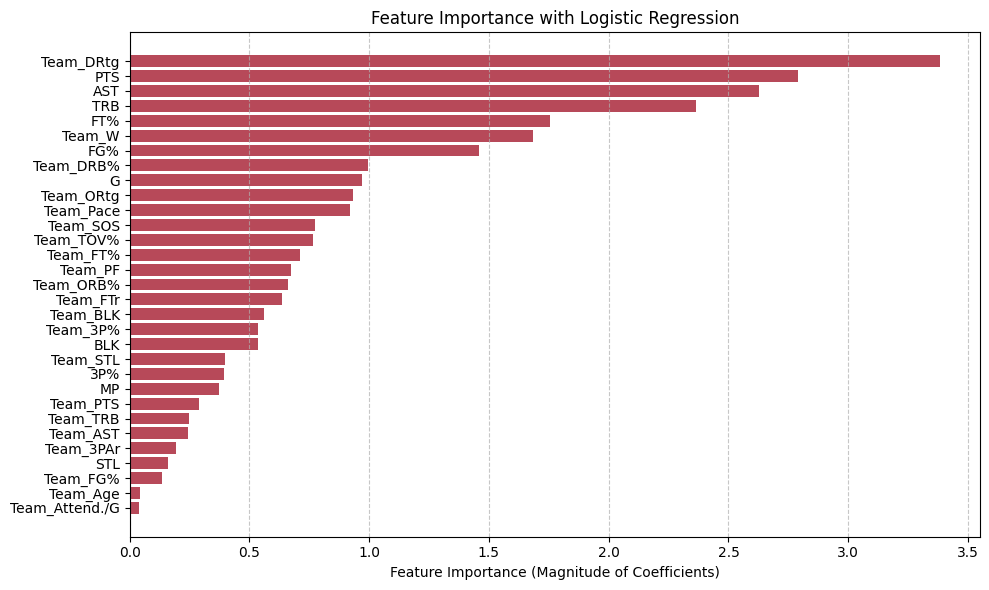

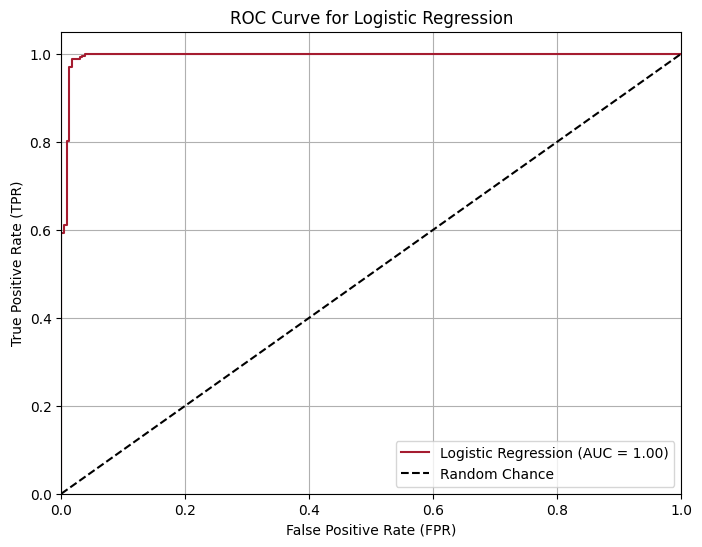

In [45]:
# Feature Importance
coefficients = baseline_model.coef_[0]
importance_mean = np.abs(coefficients)

for i in range(len(X.columns)):
    print(f"{X.columns[i]}: {coefficients[i]:.4f}")

feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importance_mean
}).sort_values(by='Importance', ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_importance)), feature_importance['Importance'], color='#A51C30', alpha=0.8)
plt.yticks(range(len(feature_importance)), feature_importance['Feature'])
plt.xlabel('Feature Importance (Magnitude of Coefficients)')
plt.title('Feature Importance with Logistic Regression')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# ROC Curve
y_proba = baseline_model.predict_proba(X_test)

fpr, tpr, _ = roc_curve(y_test, y_proba[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC = {roc_auc:.2f})', color='#A51C30')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for Logistic Regression')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


The new highest-coefficient predictor is team DRtg (defensive rating, aggregated from many defensive statistics). In the prMany stats related to DRtg were dropped due to high collinearity with DRtg itself. In any case, this does confirm the hypothesis that team performance is just as important as individual performance in predicting MVP stats, having improved our model noticeably.

# Final Model Pipeline with Team Data Included

In [46]:
X = main_df.drop(columns=["MVP"])
y = main_df["MVP"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

numeric_features = X.columns.tolist()

numeric_transformer = Pipeline(steps=[
    ('poly', PolynomialFeatures(degree=2, include_bias=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)
    ],
    remainder='passthrough'
)

log_reg = LogisticRegression(max_iter=2000, random_state=42)

param_grid = {
    'classifier__C': [0.01, 0.1, 1.0, 10.0],
    'classifier__solver': ['liblinear', 'saga'],
    'classifier__penalty': ['l1', 'l2']
}

final_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', log_reg)
])

grid_search = GridSearchCV(
    estimator=final_pipeline,
    param_grid=param_grid,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print(f"Best Cross-Validation Accuracy: {grid_search.best_score_:.4f}")

best_log_reg = grid_search.best_estimator_
y_pred = best_log_reg.predict(X_test)
y_pred_proba = best_log_reg.predict_proba(X_test)[:, 1]

print("Classification Report:\n", classification_report(y_test, y_pred, target_names=["Non-MVP", "MVP"]))

roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC-AUC Score: {roc_auc:.4f}")


Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best Parameters: {'classifier__C': 0.01, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
Best Cross-Validation Accuracy: 0.9926
Classification Report:
               precision    recall  f1-score   support

     Non-MVP       1.00      0.99      0.99       236
         MVP       0.99      1.00      0.99       236

    accuracy                           0.99       472
   macro avg       0.99      0.99      0.99       472
weighted avg       0.99      0.99      0.99       472

ROC-AUC Score: 0.9999


Including team data improves our model, bumping it up to a 99% CV accuracy. It is also unlikely that there is a lot of overfitting due to CV hyperparameter tuning since the baseline model has similar accuracy.


Selected Features and Coefficients:
G: 0.1161
FG%: 0.2818
TRB: 0.2515
MP: 0.1170
3P%: -0.0686
AST: 0.2526
STL: 0.0773
PTS: 0.3695
BLK: 0.2187
Team_Age: 0.1207
Team_W: 0.3090
Team_SOS: -0.1741
Team_DRtg: -0.2232
Team_Pace: 0.1380
Team_FTr: 0.0800
Team_3PAr: -0.0455
Team_TOV%: 0.1564
Team_ORB%: 0.0991
Team_DRB%: -0.0385
Team_Attend./G: -0.0710
Team_FG%: 0.2068
Team_3P%: -0.0212
Team_FT%: 0.0927
Team_TRB: 0.1024
Team_AST: 0.1196
Team_STL: 0.0556
Team_BLK: 0.1217
Team_PF: -0.0537
Team_PTS: 0.0873
G^2: -0.1599
G FG%: 0.0110
G TRB: 0.0241
G AST: 0.0804
G FT%: 0.0411
G STL: -0.0213
G PTS: 0.0943
G BLK: 0.0649
G Team_Age: -0.0348
G Team_W: 0.0494
G Team_SOS: 0.0513
G Team_ORtg: 0.0295
G Team_DRtg: 0.0149
G Team_Pace: 0.0201
G Team_FTr: -0.0598
G Team_3PAr: 0.0271
G Team_DRB%: 0.0238
G Team_FG%: 0.0169
G Team_3P%: -0.0302
G Team_TRB: 0.0242
G Team_STL: -0.0154
G Team_BLK: 0.0136
G Team_PF: -0.0643
G Team_PTS: 0.0277
FG% TRB: -0.0100
FG% 3P%: 0.0352
FG% AST: 0.0726
FG% FT%: -0.0107
FG% STL: 0.0

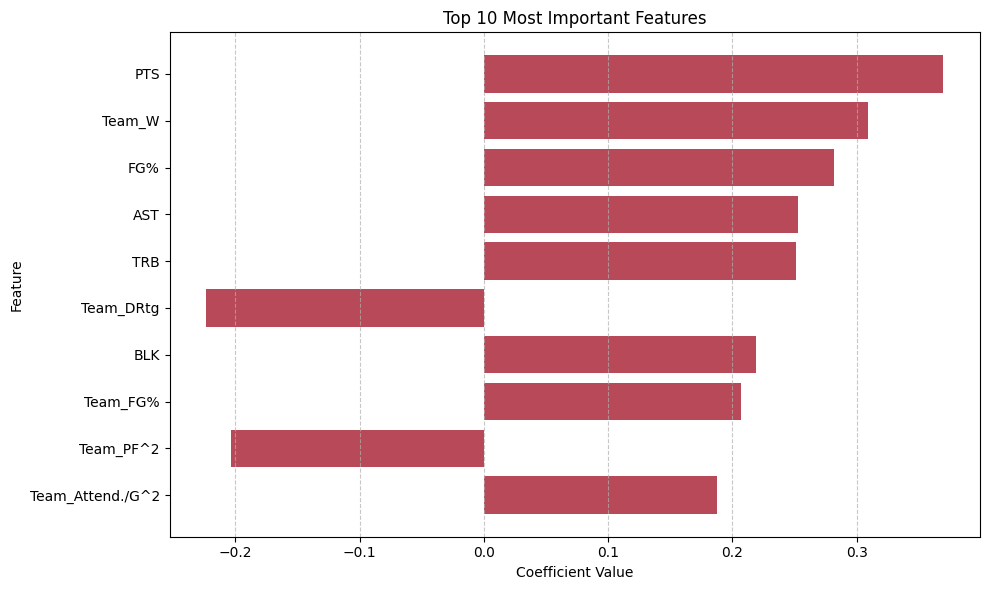

In [47]:
# Feature Importance
best_params = grid_search.best_params_

final_pipeline.set_params(
    classifier__C=best_params['classifier__C'],
    classifier__solver=best_params['classifier__solver'],
    classifier__penalty=best_params['classifier__penalty']
)

final_pipeline.fit(X_train, y_train)

coefficients = final_pipeline.named_steps['classifier'].coef_[0]

feature_names = final_pipeline.named_steps['preprocessor'].get_feature_names_out()
cleaned_features = [feature.replace("num__", "") for feature in feature_names]

feature_importance = pd.DataFrame({
    'Feature': cleaned_features,
    'Coefficient': coefficients
}).sort_values(by='Coefficient', key=abs, ascending=False)

lasso_features = {feature: coef for feature, coef in zip(cleaned_features, coefficients) if abs(coef) > 0.01}
print("\nSelected Features and Coefficients:")
for feature, coef in lasso_features.items():
    print(f"{feature}: {coef:.4f}")

# Plot the top 10 most important features
top_features = feature_importance.head(10)
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Coefficient'], alpha=0.8, color='#A51C30')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Top 10 Most Important Features')
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# Random Forest with Team Data Included

In [48]:
X = main_df.drop(columns=['MVP'])
y = main_df['MVP']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

baseline_rf = RandomForestClassifier(n_estimators=100, random_state=42)

cv_results = cross_validate(baseline_rf, X_train, y_train, cv=5, scoring='accuracy', return_train_score=True)

print(f"Mean CV Train Accuracy: {cv_results['train_score'].mean():.4f}")
print(f"Mean CV Test Accuracy: {cv_results['test_score'].mean():.4f}")

baseline_rf.fit(X_train, y_train)

y_pred = baseline_rf.predict(X_test)
y_pred_proba = baseline_rf.predict_proba(X_test)[:, 1]

# Classification report
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=["Non-MVP", "MVP"]))

# ROC-AUC score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC-AUC Score: {roc_auc:.4f}")


Mean CV Train Accuracy: 1.0000
Mean CV Test Accuracy: 0.9894
Classification Report:
               precision    recall  f1-score   support

     Non-MVP       1.00      1.00      1.00       236
         MVP       1.00      1.00      1.00       236

    accuracy                           1.00       472
   macro avg       1.00      1.00      1.00       472
weighted avg       1.00      1.00      1.00       472

ROC-AUC Score: 1.0000


## Optimized Random Forest

In [49]:
X = main_df.drop(columns=['MVP'])
y = main_df['MVP']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

rf = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print(f"Best Cross-Validation Accuracy: {grid_search.best_score_:.4f}")

best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)
y_pred_proba = best_rf.predict_proba(X_test)[:, 1]

print("Classification Report:\n", classification_report(y_test, y_pred, target_names=["Non-MVP", "MVP"]))

roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC-AUC Score: {roc_auc:.4f}")


Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Best Cross-Validation Accuracy: 0.9910
Classification Report:
               precision    recall  f1-score   support

     Non-MVP       1.00      0.99      1.00       236
         MVP       0.99      1.00      1.00       236

    accuracy                           1.00       472
   macro avg       1.00      1.00      1.00       472
weighted avg       1.00      1.00      1.00       472

ROC-AUC Score: 0.9999


With team data included, random forest has a marginally lower accuracy as logistic regression, providing another excellent model with near-perfect CV predictions.

Top 10 Most Important Features:
           Feature  Importance
11          Team_W    0.164961
8              PTS    0.108356
14       Team_DRtg    0.067922
2              TRB    0.057818
22        Team_FG%    0.055854
9              BLK    0.055034
15       Team_Pace    0.054449
1              FG%    0.049401
21  Team_Attend./G    0.041849
5              AST    0.040768


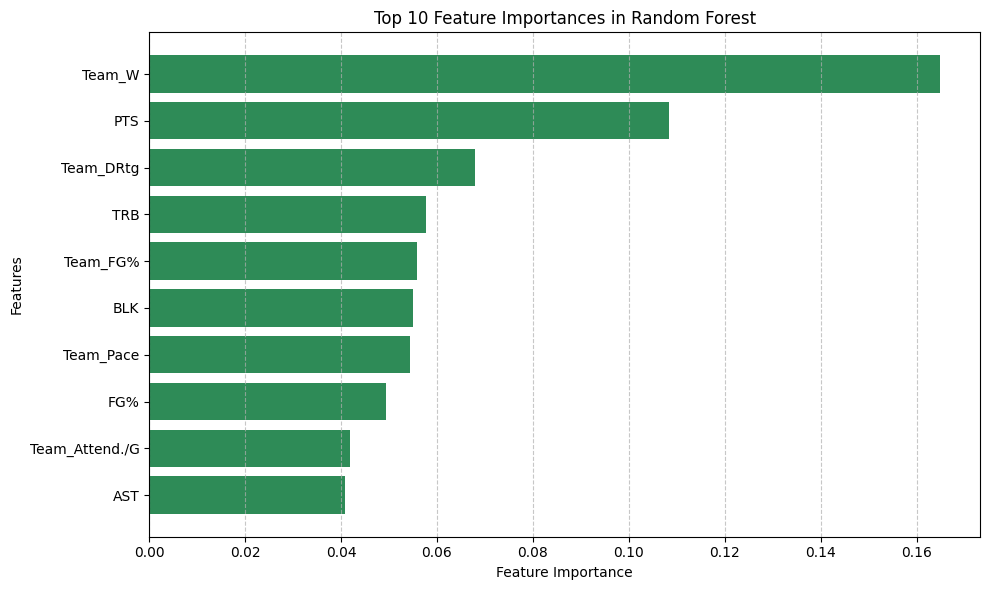

In [50]:
feature_importances = best_rf.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Display the top 10 most important features
print("Top 10 Most Important Features:")
print(feature_importance_df.head(10))

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'].head(10), feature_importance_df['Importance'].head(10), color='#2E8B57')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Top 10 Feature Importances in Random Forest')
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Top 10 Features Based on Permutation Importance:
      Feature  Importance       Std
11     Team_W    0.040254  0.007090
8         PTS    0.031780  0.006744
5         AST    0.006638  0.003033
14  Team_DRtg    0.003814  0.001585
2         TRB    0.002401  0.002368
22   Team_FG%    0.002401  0.002550
1         FG%    0.002331  0.002072
9         BLK    0.001412  0.002467
3          MP    0.000918  0.001184
15  Team_Pace    0.000777  0.001685


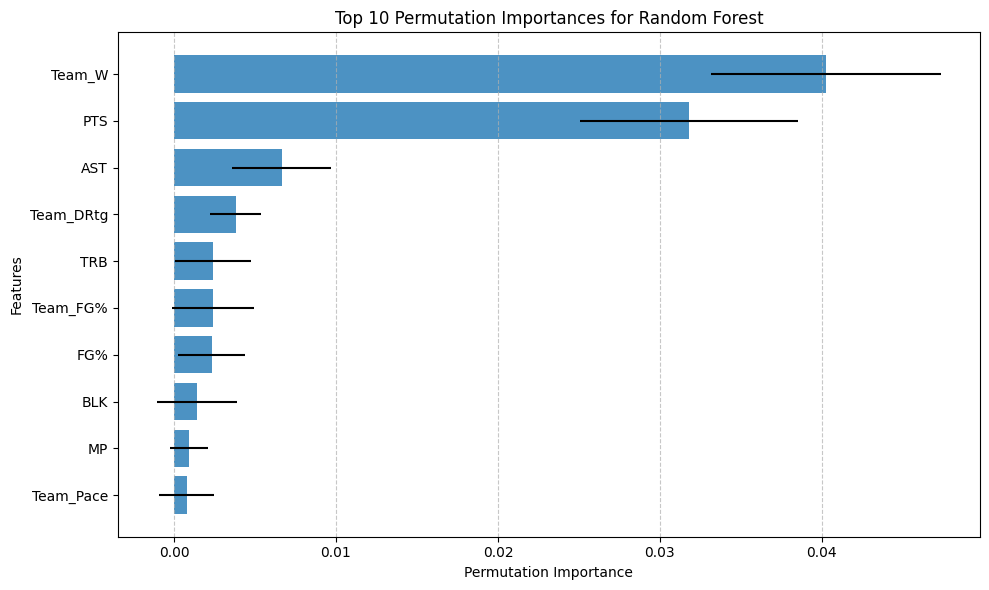

In [51]:
# Permutation Importance
perm_importance = permutation_importance(best_rf, X_test, y_test, n_repeats=30, random_state=42, n_jobs=-1)

perm_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': perm_importance.importances_mean,
    'Std': perm_importance.importances_std
}).sort_values(by='Importance', ascending=False)

# Display the top 10 most important features
print("Top 10 Features Based on Permutation Importance:")
print(perm_importance_df.head(10))

plt.figure(figsize=(10, 6))
plt.barh(perm_importance_df['Feature'].head(10), perm_importance_df['Importance'].head(10), xerr=perm_importance_df['Std'].head(10), color='#1f77b4', alpha=0.8)
plt.xlabel('Permutation Importance')
plt.ylabel('Features')
plt.title('Top 10 Permutation Importances for Random Forest')
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


As we stated in the non-team data models, feature / permutation importance provide more accurate metrics for which features are the best predictors of MVP status versus the logistic regression coefficients. Team_W (a team's win-loss record) and PTS look to be the best predictors, with the top 5 predictors consisting of half team and half individual statistics. This again supports the hypothesis that an individual's performance is just as important as their team's performance.

# Conclusion (Strengths, Limitations, Future Work)

Our project demonstrates that combining individual player statistics like points (PTS), assists (AST), and rebounds (TRB) along w/ team metrics such as wins, defensive ratings (Team_DRtG), and pace significantly improves MVP prediction accuracy. The Random Forest model (especially after hyperparameter tuning) did emerge as the strongest performer and it achieved a great cross-validated accuracy and a near-perfect ROC-AUC score. Logistic Regression also performed well as it delivered a strong cross-validated accuracy of 98.5% while offering valuable insights into feature importance. Features like rebounds (TRB), assists (AST), and team wins (Team_W) consistently ranked as top predictors across both models which highlights the importance of both well-rounded player contributions and team success in determining MVP outcomes.



One key challenge we addressed was the class imbalance caused by the small number of MVP candidates compared to non-MVPs. In order to fix this we balanced the dataset by applying the SMOTE technique which enabled the models to better identify MVPs. However this likely contributed to Logistic Regression’s slightly higher recall for MVP  (as seen in the confusion matrix) where the model prioritized true positives but exhibited minor bias toward MVP classification.



A few limitations do remain despite the overall strengths of our models. While statistical features like rebounds, assists, and team metrics were highly predictive, they fail to capture the subjective and narrative-driven factors that often influence MVP voting such as leadership and media sentiment and even exceptional late-season performances. Second, our models evaluated each season independently (so it lacked the ability to account for longitudinal trends like multi-season dominance or breakout trajectories). Finally (while Random Forest did excel at capturing complex nonlinear relationships) Random Forest’s feature importance rankings differed from Logistic Regression - which offered clearer linear insights but struggled with feature interactions.



For future work, we could aim to expand our dataset to include advanced metrics such as win shares, player impact ratings, and lineup efficiencies for a deeper understanding of MVP candidacy. Incorporating time-series analysis would allow us to track performance trends over a season and that helps in capturing momentum and consistency which are key elements in MVP voting. Additionally, exploring ensemble methods by combining Random Forest with models like XGBoost or LightGBM could further improve predictive accuracy by leveraging the unique strengths of each model. Finally, integrating narrative-driven data with something like a Narrative Score ( such as sentiment analysis from media coverage, fan voting trends, and historical voting biases) could help quantify the human elements that influence MVP selection.



Overall, our project highlights the power of combining individual and team statistics to predict MVP winners with remarkable accuracy. By adding qualitative factors and using advanced methods, we can close the gap between data-driven predictions and the real-world complexities of MVP voting, creating a more accurate and well-rounded model.

In [52]:
# Training details: Time taken
end_time = time.time()
elapsed_time = end_time - start_time

hours = int(elapsed_time // 3600)
minutes = int((elapsed_time % 3600) // 60)
seconds = int(elapsed_time % 60)

print(f"Total Runtime: {hours}h {minutes}m {seconds}s")

Total Runtime: 0h 23m 23s
